# 0.0 Imports

## 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import mlflow
import os
import gc 

from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, FloatType, LongType, ShortType

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score


## 0.2 Setting MLflow

In [2]:
# # use this to change mlflow folder
# mlflow.set_tracking_uri("file:///home/humberto/DS/fraud_detection/reports/mlruns")

In [15]:
experiment_id = mlflow.create_experiment("attempting to calibrate some models")
experiment = mlflow.get_experiment(experiment_id)
experiment

<Experiment: artifact_location='file:///home/humberto/DS/fraud_detection/notebooks/mlruns/2', experiment_id='2', lifecycle_stage='active', name='attempting to calibrate some models', tags={}>

In [6]:
# # use this standard
# mlflow.start_run(experiment_id=experiment_id)
# mlflow.log_param('max_depth', 16)
# mlflow.log_metric('recall', 0.89)
# mlflow.end_run()

## 0.2 Starting Spark Session

In [2]:
spark = (SparkSession
.builder
.config("spark.driver.memory", "4g")
.appName('Fraud')
.getOrCreate())

spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/24 11:30:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%%time
spark = SparkSession.builder.appName("MyApp") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
            .config("spark.driver.memory", "4g") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .getOrCreate()

import synapse.ml

https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1


:: loading settings :: url = jar:file:/home/humberto/.pyenv/versions/3.8.0/envs/pyspark/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/humberto/.ivy2/cache
The jars for the packages stored in: /home/humberto/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b31f2b77-6ffc-4150-b063-ef00f04c9f1a;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.9.5 in central
	found com.microsoft.azure#synapseml-core_2.12;0.9.5 in central
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuu

CPU times: user 530 ms, sys: 82.9 ms, total: 613 ms
Wall time: 1min


## 0.3 Helper Functions



In [3]:
import matplotlib.pyplot as plt

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    # plt.style.use( 'seaborn-notebook' )
    # plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    plt.rcParams['figure.facecolor'] = 'white'
    
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    # sns.set()

jupyter_settings()

def proba_to_pandas(dataframe, prob_col:str, label_col:str):
    """
    Converts a PySpark SQL DataFrame's probability and label columns to a pandas dataframe.
    """
    # convert to pandas df
    result = dataframe.select([prob_col, label_col]).toPandas()
    
    # rename cols
    result.columns = ['y_pred', 'y_true']

    # select proba of positive class
    result['y_pred'] = result['y_pred'].apply(lambda x : x[1])
    
    return result

def describe_stats(dataframe):
    """
    Calculates min, max, mean, std, skewnewss and kurtosis for the given pyspark df
    and returns a pandas df with the results.
    """
    import pyspark.sql. functions as funcs
    num_cols = [f.name for f in dataframe.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType, LongType, ShortType))]

    min = []
    max = []
    mean = []
    std = []
    skewness = []
    kurtosis = []

    for col in num_cols:
        # evaluates each metric, collect (to execute) and extracts the result to append to lis
        min.append( data.agg( funcs.min(col) ).collect()[0][0] )
        max.append( data.agg( funcs.max(col) ).collect()[0][0] )
        mean.append( data.agg( funcs.mean(col) ).collect()[0][0] )
        std.append( data.agg( funcs.stddev(col) ).collect()[0][0] )
        skewness.append( data.agg( funcs.skewness(col) ).collect()[0][0] )
        kurtosis.append( data.agg( funcs.kurtosis(col) ).collect()[0][0] )

    # create a dataframe with results
    res = {'min': min, 'max': max, 'mean': mean, 'std': std, 'skewness': skewness, 'kurtosis': kurtosis}
    return pd.DataFrame(res, index = num_cols)

## 0.4 Data Loading

In [4]:
%%time
data = spark.read.csv('../data/raw/fraud.csv', header = True, inferSchema=True) #.cache()

CPU times: user 17.8 ms, sys: 3.69 ms, total: 21.5 ms
Wall time: 37.5 s


In [9]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [8]:
type(data)

pyspark.sql.dataframe.DataFrame

In [9]:
data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

## 0.5 Columns Description



**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** -
amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1.0 Data Description


## 1.1 Rename Columns

In [5]:
# new column names
cols = ['step',
 'type',
 'amount',
 'name_orig',
 'old_balance_org',
 'new_balance_org',
 'name_dest',
 'old_balance_dest',
 'new_balance_dest',
 'is_fraud',
 'is_flagged_fraud']

data = data.toDF(*cols)
data.show()

+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+
|step|    type|   amount|  name_orig|old_balance_org|new_balance_org|  name_dest|old_balance_dest|new_balance_dest|is_fraud|is_flagged_fraud|
+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+
|   1| PAYMENT|  9839.64|C1231006815|       170136.0|      160296.36|M1979787155|             0.0|             0.0|       0|               0|
|   1| PAYMENT|  1864.28|C1666544295|        21249.0|       19384.72|M2044282225|             0.0|             0.0|       0|               0|
|   1|TRANSFER|    181.0|C1305486145|          181.0|            0.0| C553264065|             0.0|             0.0|       1|               0|
|   1|CASH_OUT|    181.0| C840083671|          181.0|            0.0|  C38997010|         21182.0|             0.0|       1|               0|
|   1|

## 1.2 Data Dimensions

## 1.3 Data Types

## 1.4 NA Check

In [6]:
columns = data.columns


NAs = {col: data[data[col].isNull()].count() for col in columns }

NAs

{'step': 0,
 'type': 0,
 'amount': 0,
 'name_orig': 0,
 'old_balance_org': 0,
 'new_balance_org': 0,
 'name_dest': 0,
 'old_balance_dest': 0,
 'new_balance_dest': 0,
 'is_fraud': 0,
 'is_flagged_fraud': 0}

## 1.5 NA Fillout

## 1.6 Changing Data Types


In [13]:
data.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- name_orig: string (nullable = true)
 |-- old_balance_org: double (nullable = true)
 |-- new_balance_org: double (nullable = true)
 |-- name_dest: string (nullable = true)
 |-- old_balance_dest: double (nullable = true)
 |-- new_balance_dest: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_flagged_fraud: integer (nullable = true)



## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [7]:
desc = describe_stats(data)
# 8 min to run

In [8]:
desc.style.format("{:,.2f}")

,min,max,mean,std,skewness,kurtosis
step,1.00,743.00,243.40,142.33,0.38,0.33
amount,0.00,"92,445,516.64","179,861.90","603,858.23",30.99,"1,797.96"
old_balance_org,0.00,"59,585,040.37","833,883.10","2,888,242.67",5.25,32.96
new_balance_org,0.00,"49,585,040.37","855,113.67","2,924,048.50",5.18,32.07
old_balance_dest,0.00,"356,015,889.35","1,100,701.67","3,399,180.11",19.92,948.67
new_balance_dest,0.00,"356,179,278.92","1,224,996.40","3,674,128.94",19.35,862.16
is_fraud,0.00,1.00,0.00,0.04,27.78,769.70
is_flagged_fraud,0.00,1.00,0.00,0.00,630.60,"397,658.75"


In [9]:
desc.style.format("{:,.4f}")

,min,max,mean,std,skewness,kurtosis
step,1.0000,743.0000,243.3972,142.3320,0.3752,0.3291
amount,0.0000,"92,445,516.6400","179,861.9035","603,858.2315",30.9939,"1,797.9553"
old_balance_org,0.0000,"59,585,040.3700","833,883.1041","2,888,242.6730",5.2491,32.9649
new_balance_org,0.0000,"49,585,040.3700","855,113.6686","2,924,048.5030",5.1769,32.0670
old_balance_dest,0.0000,"356,015,889.3500","1,100,701.6665","3,399,180.1130",19.9218,948.6734
new_balance_dest,0.0000,"356,179,278.9200","1,224,996.3982","3,674,128.9421",19.3523,862.1558
is_fraud,0.0000,1.0000,0.0013,0.0359,27.7795,769.7024
is_flagged_fraud,0.0000,1.0000,0.0000,0.0016,630.6035,"397,658.7500"


In [10]:
# frauds = prop.iloc[0,1]
# non_frauds = prop.iloc[1,1]

# print('fraud percentage: {:.4f}%'.format( 100*frauds/(frauds+non_frauds)))


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

## 2.1 Response Variable Mind Map

## 2.2 Hypothesis List

- fraudulent transactions withdraw more than 50% of destination acc balance
- fraudulent transactions withdraw 100% of origin acc balance
- fraudulent transactions peak at some exclusive time
- most fraud flagged transactions are not fraud
- most fraudulent transactions are related to new accounts

## 2.3 Selected Hypothesis:

**H1:** Fraudulent transactions withdraw more than 50% of destination acc balance

**H2:** Fraudulent transactions withdraw 100% of origin acc balance

**H3:** Fraudulent transactions peak at some exclusive time

**H4:** Most fraud flagged transactions are not fraud

**H5:** Most fraudulent transactions are related to new accounts

## 2.4 Feature Engineering

### 2.4.1 datetime

In [6]:
data = data.withColumn("hour", data['step']%24.0)
data.select(['hour']).show(5)

+----+
|hour|
+----+
| 1.0|
| 1.0|
| 1.0|
| 1.0|
| 1.0|
+----+
only showing top 5 rows



### 2.4.2 delta percentage of balance

In [7]:
data = data.withColumn('delta_balance_org', (data['new_balance_org'] - data['old_balance_org'])/data['old_balance_org'] )
data = data.withColumn('delta_balance_dest', (data['new_balance_dest'] - data['old_balance_dest'])/data['old_balance_dest'] )
data = data.fillna(0)

In [8]:
data['delta_balance_org', 'delta_balance_dest'].show()

+--------------------+--------------------+
|   delta_balance_org|  delta_balance_dest|
+--------------------+--------------------+
|-0.05783396811962...|                 0.0|
|-0.08773495223304621|                 0.0|
|                -1.0|                 0.0|
|                -1.0|                -1.0|
|-0.28079462867593974|                 0.0|
|-0.14514871890085404|                 0.0|
|-0.03879893010180403|                 0.0|
|-0.04464628127775088|                 0.0|
|                -1.0|                 0.0|
|-0.12794271332694143|-0.03697575063248...|
|                -1.0|  13.567277086214846|
|-0.14924510134321897|                 0.0|
|  -0.505076923076923|                 0.0|
|                -1.0|                 0.0|
|-0.00814439339988...|                 0.0|
|                -1.0|   9.134456029903602|
|                -1.0|                 0.0|
|-0.05472962752883345|                 0.0|
|-0.04441182305098191|                 0.0|
|                -1.0|          

### 2.4.3 Nº of transactions done with customer

In [14]:
# data[['name_orig']].distinct().count()

# it wont be possible to count the amount of transactions a customer has done with the destination customer
# since we have almost only unique customers

### Type

In [10]:
# data[ data['type'] == 'CASH_IN' ].show(5)
# data[ (data['type'] == 'CASH_IN') & (data['isFraud'] == 1) ].show(5)

# data[ data['isFraud'] == 1 ]
# data.filter(data.isFraud == 1).select('type').distinct().show() # frauds only happened on transfer and cash out

# data.filter(data.isFraud == 1).select('nameDest').distinct().count() # 


# 3.0 Variable Selection

In [14]:
# numerical variables

data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('name_orig', 'string'),
 ('old_balance_org', 'double'),
 ('new_balance_org', 'double'),
 ('name_dest', 'string'),
 ('old_balance_dest', 'double'),
 ('new_balance_dest', 'double'),
 ('is_fraud', 'int'),
 ('is_flagged_fraud', 'int')]

In [14]:
# Selecting cols and transformers to apply RF

# #('step', 'int'), use later
# ('type', 'string'), # OHE
# ('amount', 'double'), 
# # ('nameOrig', 'string'),
# ('oldbalanceOrg', 'double'),
# ('newbalanceOrig', 'double'),
# # ('nameDest', 'string'),
# ('oldbalanceDest', 'double'),
# ('newbalanceDest', 'double'),
# ('isFraud', 'int'),
# # ('isFlaggedFraud', 'int')

num_cols = ['amount','old_balance_org','new_balance_org','old_balance_dest','new_balance_dest', 'is_flagged_fraud', 'hour','delta_balance_org','delta_balance_dest']
cat_cols = ['type']

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

In [9]:
# using a 10% sample to draw inferences

sample = data.sampleBy('is_fraud', {0: 0.1, 1:0.1}, seed = 42 ).toPandas()
print(sample.shape)
sample.head()

(636095, 14)


,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,1.0,-0.044646,0.000000
1,1,PAYMENT,1563.82,C761750706,450.00,0.00,M1731217984,0.0,0.00,0,0,1.0,-1.000000,0.000000
2,1,PAYMENT,671.64,C2033524545,15123.00,14451.36,M473053293,0.0,0.00,0,0,1.0,-0.044412,0.000000
3,1,PAYMENT,2641.47,C460570271,23053.00,20411.53,M1653361344,0.0,0.00,0,0,1.0,-0.114582,0.000000
4,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,C1937962514,517.0,8383.29,0,0,1.0,-0.791400,15.215261


In [13]:
# sample.to_csv('../data/interim/sample.csv', index = False)

sample = pd.read_csv('../data/interim/sample.csv')

In [14]:
sample.tail()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
636090,740,CASH_OUT,748139.48,C959562247,748139.48,0.0,C1768725891,0.00,748139.48,1,0,20.0,-1.0,0.000000
636091,740,CASH_OUT,1755647.81,C1724432558,1755647.81,0.0,C22170584,2930014.23,4685662.04,1,0,20.0,-1.0,0.599194
636092,741,TRANSFER,114149.44,C1157446475,114149.44,0.0,C1367473638,0.00,0.00,1,0,21.0,-1.0,0.000000
636093,742,TRANSFER,652993.91,C40604503,652993.91,0.0,C1166857907,0.00,0.00,1,0,22.0,-1.0,0.000000
636094,742,TRANSFER,303846.74,C959102961,303846.74,0.0,C114421319,0.00,0.00,1,0,22.0,-1.0,0.000000


In [16]:
# removing delta balance dest
sample.drop('delta_balance_dest', axis = 1, inplace = True)

# creating variation of destination balance
sample['var_balance_dest'] = sample['new_balance_dest'] - sample['old_balance_dest']

# selecting only fraudulent transactions
fraud_sample = sample.loc[ sample['is_fraud'] == 1].copy()
fraud_sample['delta_balance_org'] = fraud_sample['delta_balance_org']*100


### 4.1.1 Response Variable

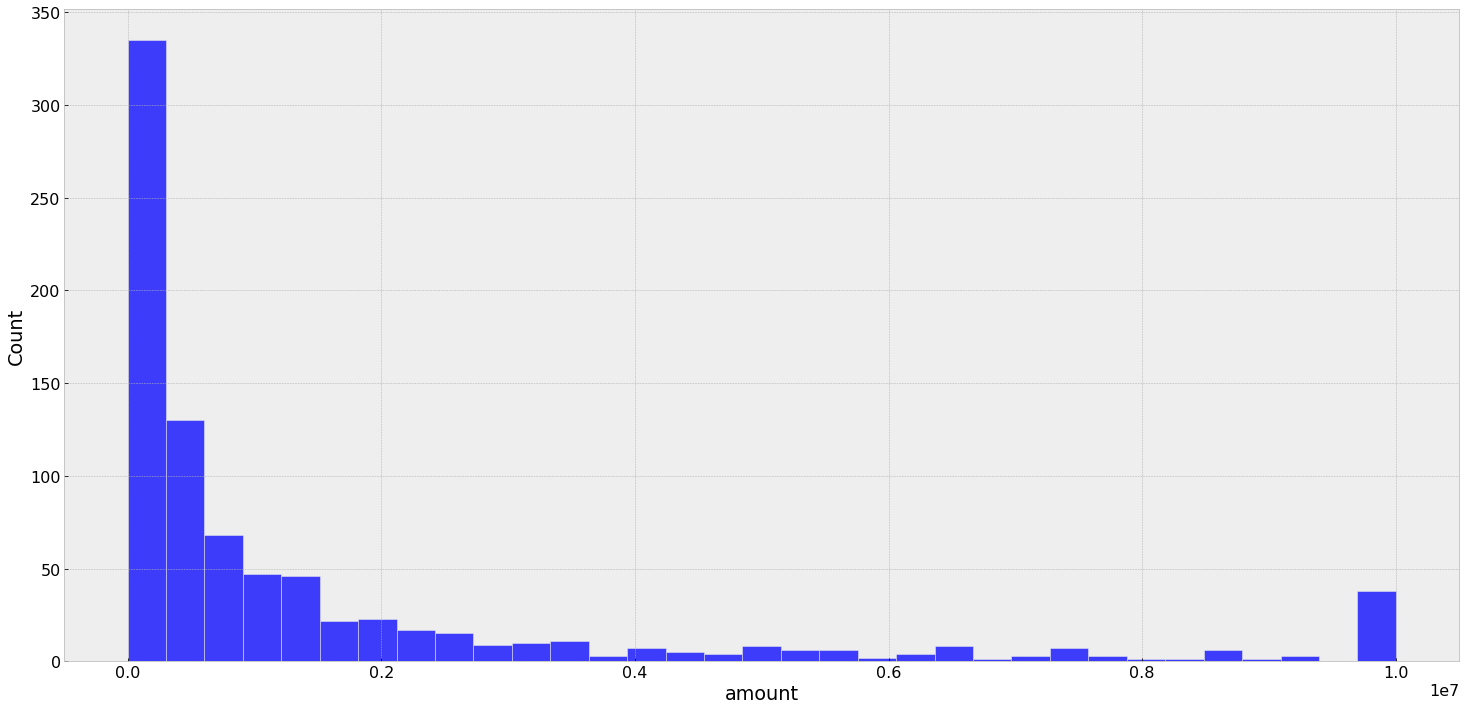

In [22]:
sns.histplot(fraud_sample, x = 'amount');

### 4.1.2 Numerical Variables

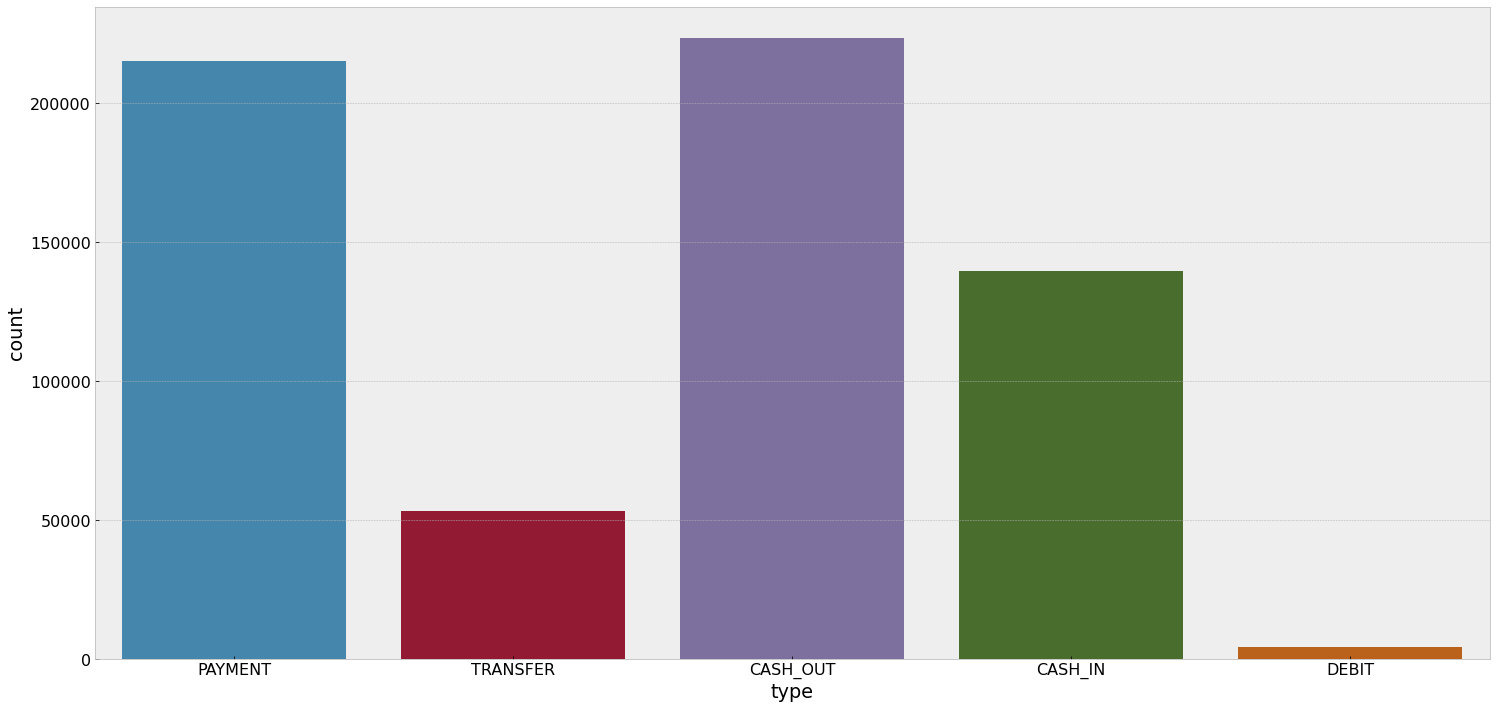

In [26]:
# type
sns.countplot(data = sample, x = 'type');

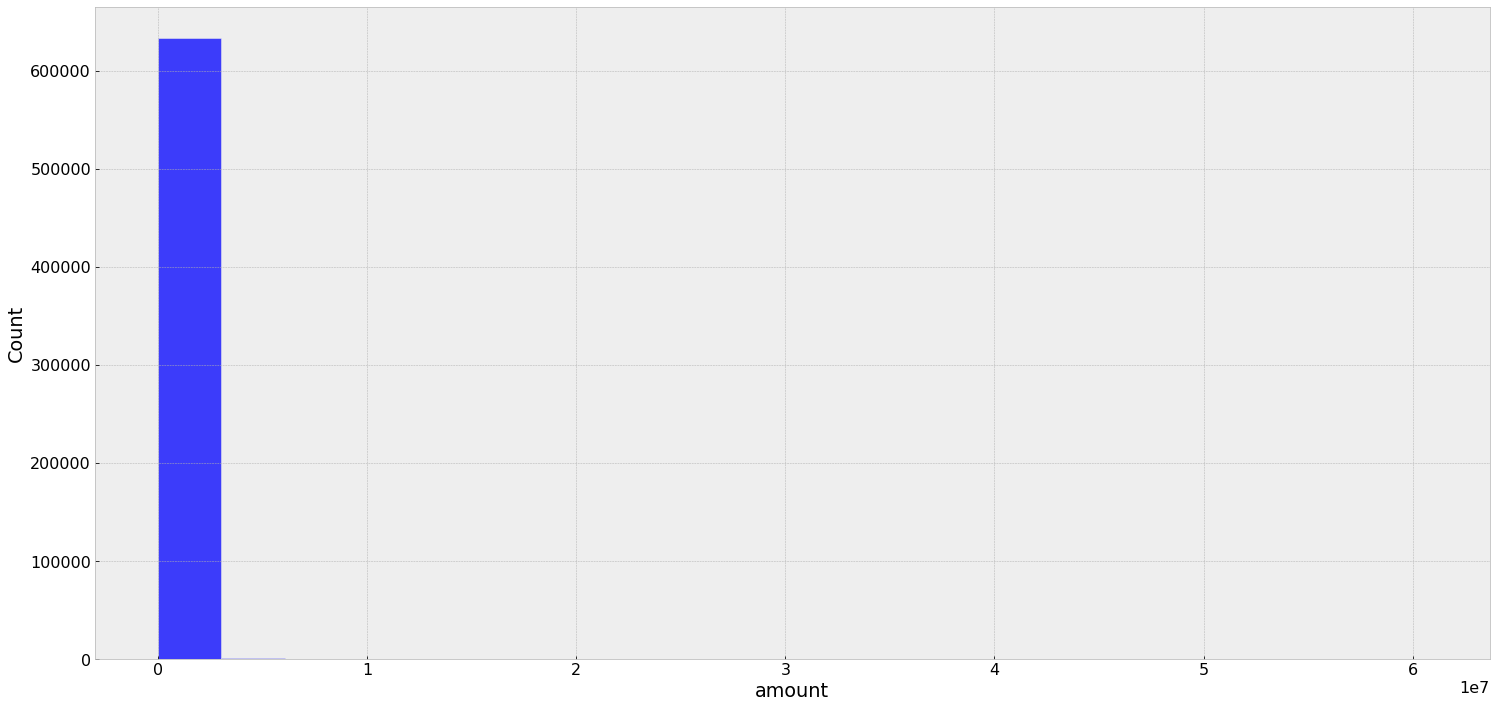

In [31]:
# amount
sns.histplot(sample, x = 'amount', bins = 20);

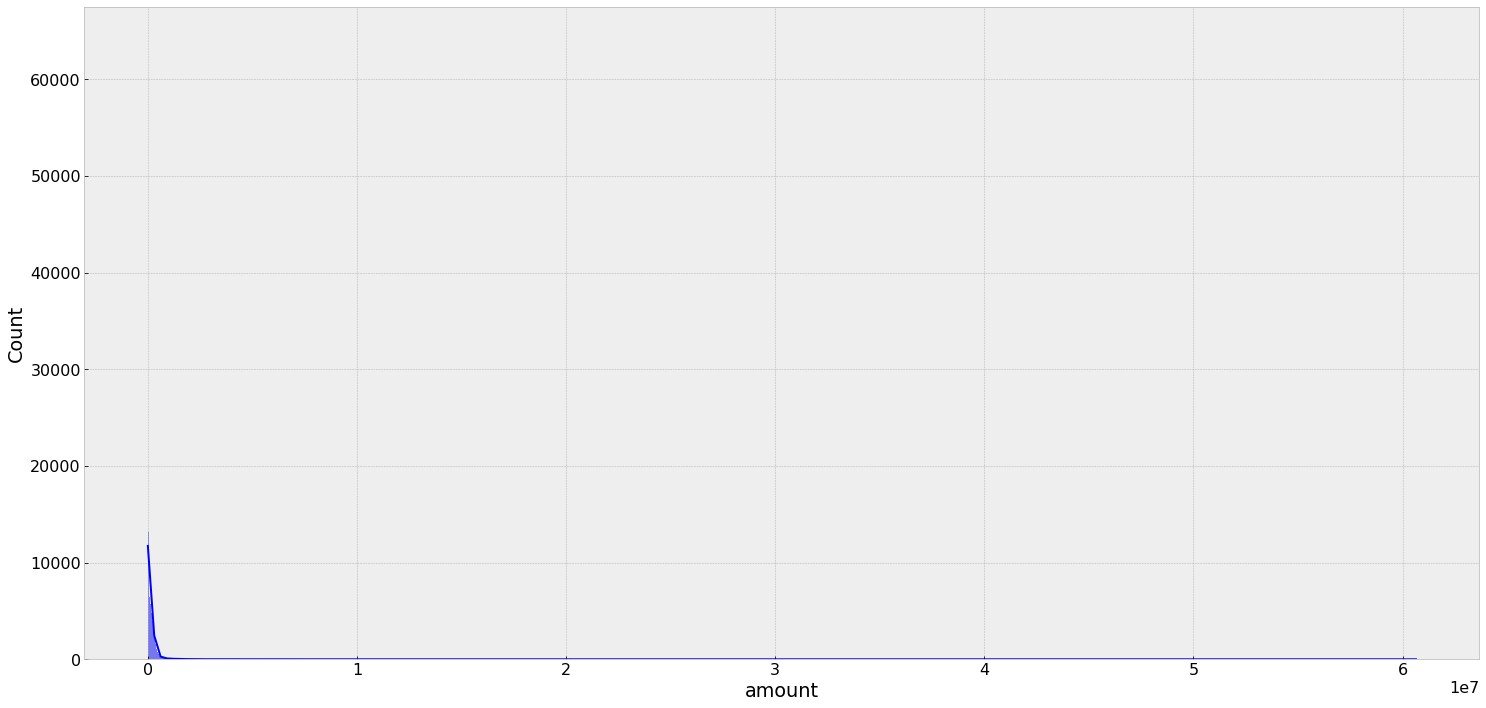

In [30]:
sns.histplot(sample, x = 'amount', kde = True);

### 4.1.3 Categorical Variables

## 4.2 Bivariate Analysis

In [17]:
fraud_sample.sort_values('type').tail(5)

# cash out = balance dest increases
# trasnfer = balance dest 0

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,var_balance_dest
599382,422,TRANSFER,298365.86,C331578052,298365.86,0.0,C18819667,0.0,0.0,1,0,14.0,-100.0,0.0
599356,422,TRANSFER,40591.72,C1817821840,40591.72,0.0,C1446237995,0.0,0.0,1,0,14.0,-100.0,0.0
163207,157,TRANSFER,4738282.28,C1533698204,4738282.28,0.0,C1200872138,0.0,0.0,1,0,13.0,-100.0,0.0
600792,438,TRANSFER,176776.55,C1282030759,176776.55,0.0,C2119586471,0.0,0.0,1,0,6.0,-100.0,0.0
636094,742,TRANSFER,303846.74,C959102961,303846.74,0.0,C114421319,0.0,0.0,1,0,22.0,-100.0,0.0


### **H1:** Fraudulent transactions withdraw more than 50% of destination acc balance
TRUE: Almost 60% of fraudulent transactions withdrow the entire transactioned amount

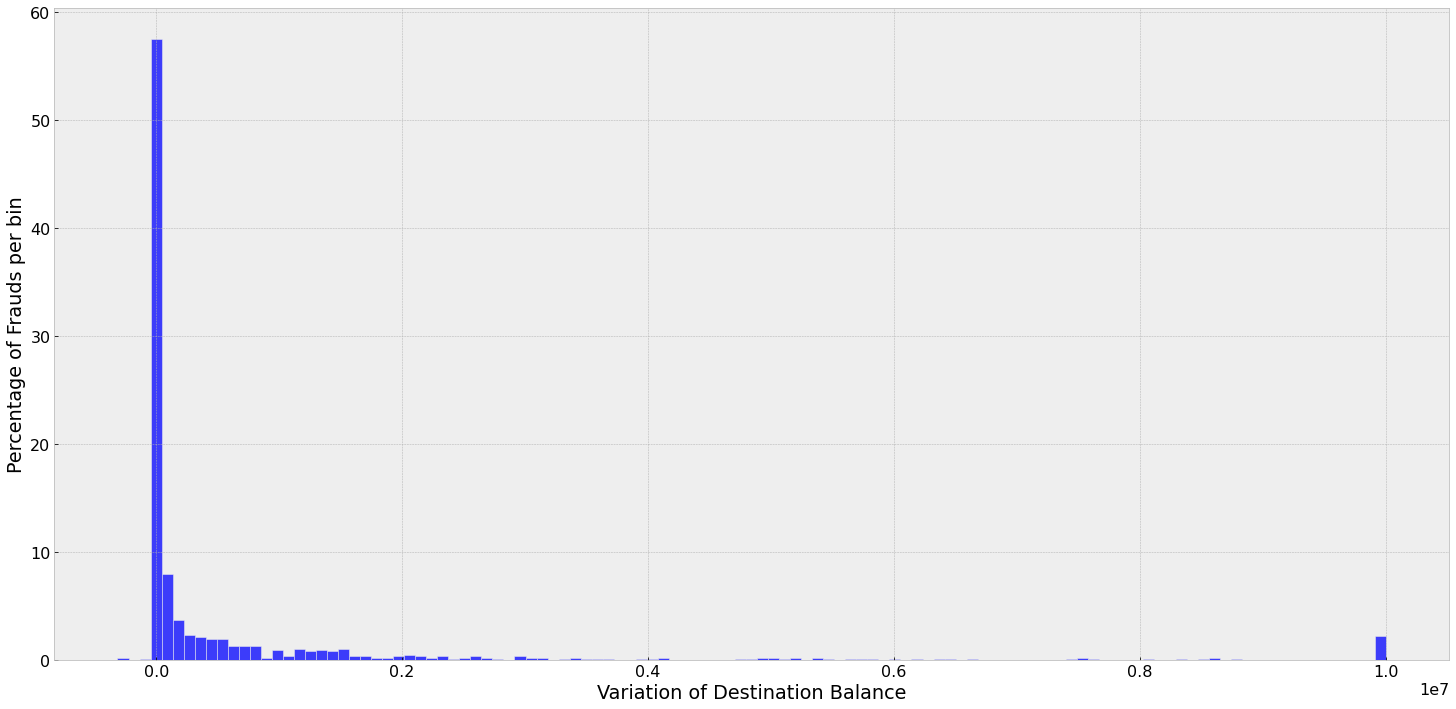

In [20]:
plt.xlabel('Variation of Destination Balance')
plt.ylabel('Percentage of Frauds per bin')
sns.histplot(fraud_sample, x = 'var_balance_dest', stat='percent');

### **H2.** Fraudulent transactions withdraw 100% of origin acc balance
TRUE: Almost 100% of fraudulent transactions present this behaviour


In [41]:
# sns.scatterplot(x = 'amount', y = 'delta_balance_org', hue = 'is_fraud', data = sample);
sns.histplot(x = 'delta_balance_org', y = 'is_fraud', data= sample);

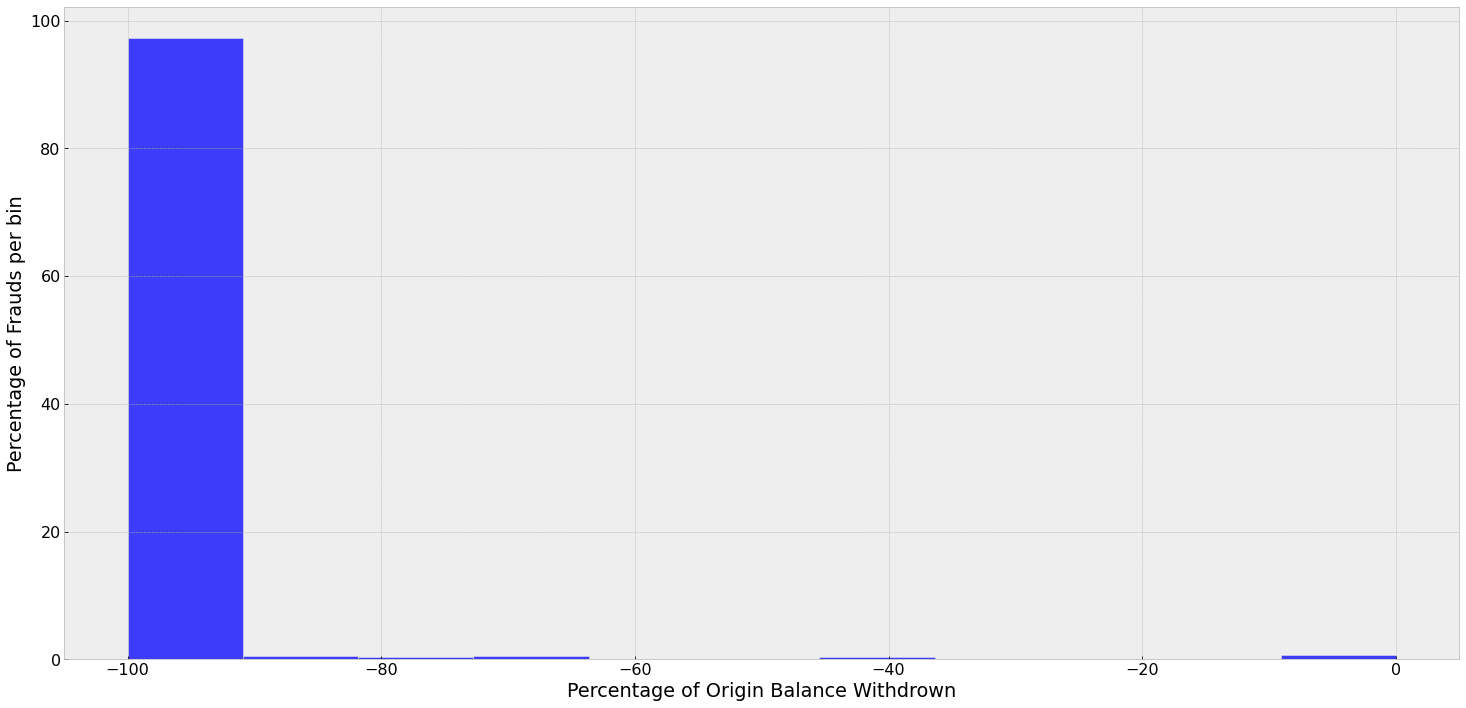

In [32]:
plt.xlabel('Percentage of Origin Balance Withdrown')
plt.ylabel('Percentage of Frauds per bin')
sns.histplot(fraud_sample, x = 'delta_balance_org', stat='percent');


### **H3.** Fraudulent transactions peak at some exclusive time
False: The number of frauds, the average and maximum amount of frauds is time independent and presents a stochastic behaviour 

In [8]:
# fraud_time = data.where( data['is_fraud'] == 1 ).select('hour', 'is_fraud').groupBy('hour').count().alias('n_frauds').toPandas()

# calculating sum of fraud amount for each hour
fraud_time = ( data.where( data['is_fraud'] == 1 )
    .select( 'hour', 'is_fraud', 'amount')
    .groupBy('hour')
    .agg( {'is_fraud':'count', 'amount':'sum'} )
    .withColumnRenamed('count(is_fraud)', 'n_frauds')
    .withColumnRenamed('sum(amount)', 'sum_of_amount')
    .toPandas() )

# calculating avg of fraud amount for each hour
fraud_time_aux = ( data.where( data['is_fraud'] == 1 )
    .select( 'hour', 'is_fraud', 'amount')
    .groupBy('hour')
    .agg( {'amount':'avg'} )
    .withColumnRenamed('count(is_fraud)', 'n_frauds')
    .withColumnRenamed('avg(amount)', 'avg_amount')
    .toPandas() )

In [9]:
fraud_time = fraud_time.merge(fraud_time_aux, how='left', on = 'hour')
fraud_time = fraud_time.sort_values('hour', ascending = True)
fraud_time

,hour,sum_of_amount,n_frauds,avg_amount
1,0.0,4.093770e+08,300,1.364590e+06
4,1.0,3.666856e+08,358,1.024262e+06
13,2.0,7.001793e+08,372,1.882202e+06
11,3.0,6.285601e+08,326,1.928098e+06
5,4.0,3.405823e+08,274,1.243001e+06
19,5.0,5.027237e+08,366,1.373562e+06
17,6.0,4.461864e+08,358,1.246331e+06
2,7.0,3.303116e+08,328,1.007048e+06
0,8.0,6.213458e+08,368,1.688440e+06
21,9.0,4.130749e+08,341,1.211363e+06


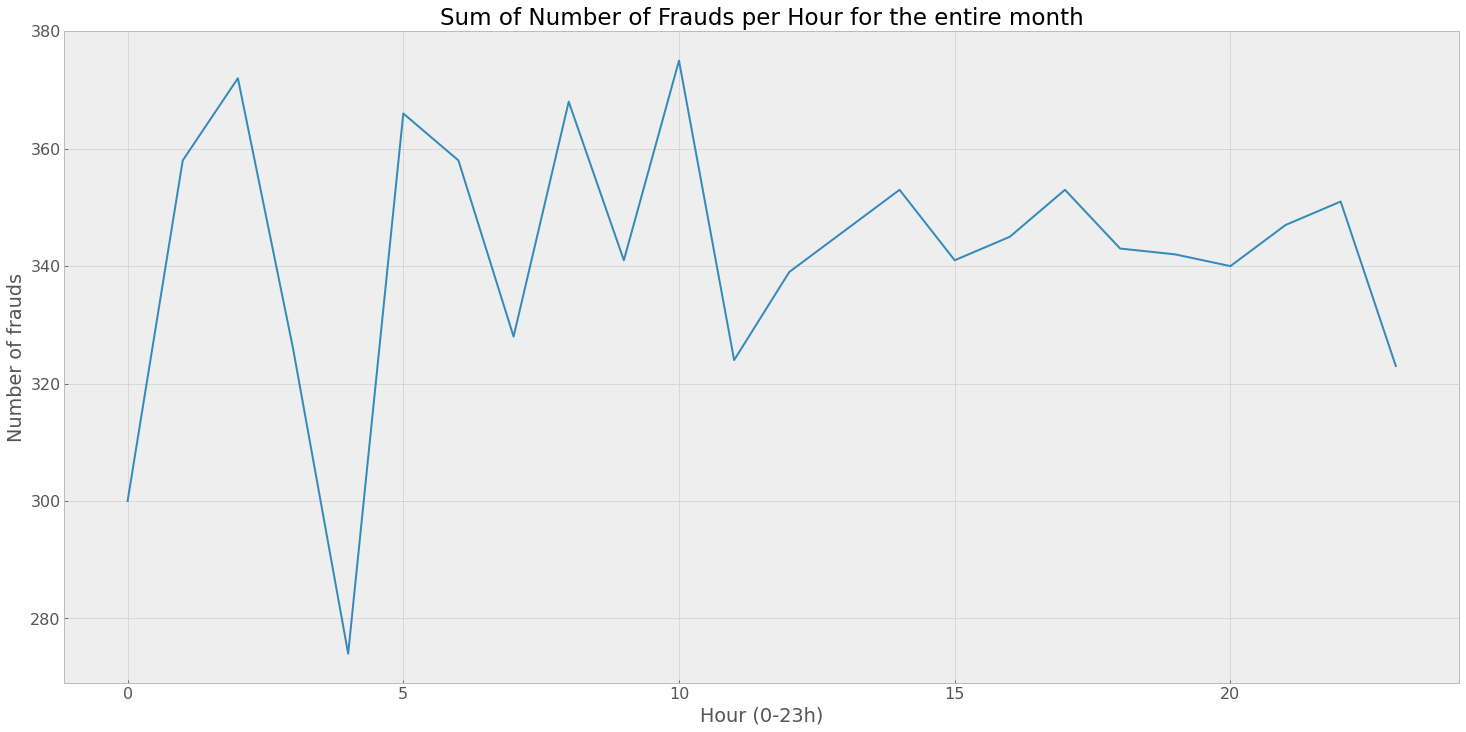

In [19]:
sns.lineplot(x = 'hour', y = 'n_frauds', data = fraud_time);
plt.title('Sum of Number of Frauds per Hour for the entire month')
plt.xlabel('Hour (0-23h)')
plt.ylabel('Number of frauds');

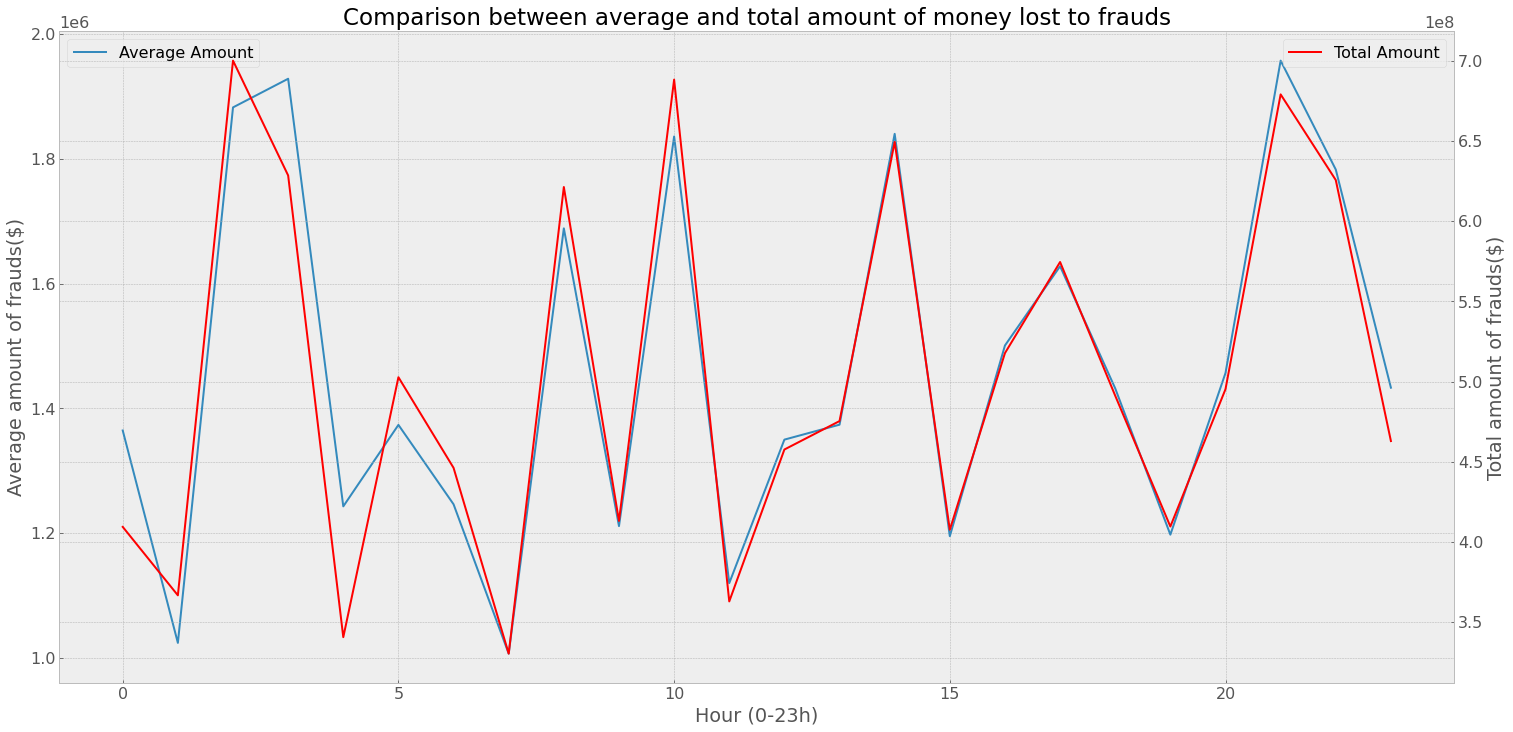

In [36]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(x = 'hour', y = 'avg_amount', data = fraud_time, ax=ax1, label = 'Average Amount');
sns.lineplot(x = 'hour', y = 'sum_of_amount', data = fraud_time, ax=ax2, color = "r", label = 'Total Amount');
ax1.legend()
ax1.set_title('Comparison between average and total amount of money lost to frauds')
ax1.set_xlabel('Hour (0-23h)')
ax1.set_ylabel('Average amount of frauds($)')
ax2.set_ylabel('Total amount of frauds($)');


### **H4.** Most fraud flagged transactions are not fraud

FALSE: All flagged transactions are indeed fraudulent, however only a very small amount of transactions was flagged (for unknown reasons)

In [15]:
n_frauds = data.where( data['is_fraud'] == 1).count()
n_frauds

8213

In [16]:
flagged = data.where( data['is_flagged_fraud'] == 1).count()
flagged

16

In [27]:
flagged = data.where( data['is_flagged_fraud'] != 1).count()
flagged

6362604

In [26]:
flagged_and_fraud = data.where( (data['is_flagged_fraud'] == 1) & (data['is_fraud'] == 1) ).count()
flagged_and_fraud

16

In [23]:
flags = data.where( data['is_flagged_fraud'] == 1).to_pandas_on_spark()
flags

22/05/21 15:26:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 15:26:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
0,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,20.0,0.0,0.0
1,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,10.0,0.0,0.0
2,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,15.0,0.0,0.0
3,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,3.0,0.0,0.0
4,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,17.0,0.0,0.0
5,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,17.0,0.0,0.0
6,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,2.0,0.0,0.0
7,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,10.0,0.0,0.0
8,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,17.0,0.0,0.0
9,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,22.0,0.0,0.0


In [40]:
print("Frauds in period: {}".format(n_frauds))
print("Frauds flagged as frauds : {}".format(flagged_and_fraud))
print("Percentage of flagged frauds : {:.3f}%".format(flagged_and_fraud/n_frauds*100))


Frauds in period: 8213
Frauds flagged as frauds : 16
Percentage of flagged frauds : 0.195%


### **H5.** Most fraudulent transactions are related to new accounts

In [21]:
sample.head()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,var_balance_dest
0,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,1.0,-0.044646,0.00
1,1,PAYMENT,1563.82,C761750706,450.00,0.00,M1731217984,0.0,0.00,0,0,1.0,-1.000000,0.00
2,1,PAYMENT,671.64,C2033524545,15123.00,14451.36,M473053293,0.0,0.00,0,0,1.0,-0.044412,0.00
3,1,PAYMENT,2641.47,C460570271,23053.00,20411.53,M1653361344,0.0,0.00,0,0,1.0,-0.114582,0.00
4,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,C1937962514,517.0,8383.29,0,0,1.0,-0.791400,7866.29


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# 5.0 Data Preparation

In [13]:
data.limit(5).toPandas()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1.0,-0.057834,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1.0,-0.087735,NaN
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1.0,-1.000000,NaN
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0,-1.000000,-1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1.0,-0.280795,NaN


## 5.1 Data Preparation

In [15]:
data = data.fillna(0)
data.limit(5).toPandas()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1.0,-0.057834,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1.0,-0.087735,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1.0,-1.000000,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0,-1.000000,-1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1.0,-0.280795,0.0


In [16]:
# preprocessing
selected_cols = num_cols + ['type_ohe']

# type category to idx
string_indx = StringIndexer(inputCols=['type'], outputCols=['type_idx'])

# ohe of type category idx
ohe = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_ohe'])

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

prep_pipe = Pipeline(stages=[string_indx, ohe, vec_asm ])

# defining preprocessor 
processed_data = prep_pipe.fit(data).transform(data)

## 5.2 Train Test Split

In [20]:
# train test split yielding 80% 20% split, stratified on response variable
data.unpersist()

train = processed_data.sampleBy( col='is_fraud', fractions = {0:0.8, 1:0.8}, seed = 42 ).cache()
test = processed_data.exceptAll(train).cache()

processed_data.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double, type_idx: double, type_ohe: vector, features: vector]

## 5.3 One hot encoding

In [13]:
selected_cols = num_cols + ['type_ohe']

# type category to idx
string_indx = StringIndexer(inputCols=['type'], outputCols=['type_idx'])

# ohe of type category idx
ohe = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_ohe'])

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

## 5.4 All steps

In [4]:
%%time
data = spark.read.csv('../data/raw/fraud.csv', header = True, inferSchema=True) #.cache()

# new column names
cols = ['step',
 'type',
 'amount',
 'name_orig',
 'old_balance_org',
 'new_balance_org',
 'name_dest',
 'old_balance_dest',
 'new_balance_dest',
 'is_fraud',
 'is_flagged_fraud']
data = data.toDF(*cols)

# creating features
data = data.withColumn("hour", data['step']%24.0)
data = data.withColumn('delta_balance_org', (data['new_balance_org'] - data['old_balance_org'])/data['old_balance_org'] )
data = data.withColumn('delta_balance_dest', (data['new_balance_dest'] - data['old_balance_dest'])/data['old_balance_dest'] )

# Selecting cols and transformers to apply RF
num_cols = ['amount','old_balance_org','new_balance_org','old_balance_dest','new_balance_dest', 'is_flagged_fraud', 'hour','delta_balance_org','delta_balance_dest']
cat_cols = ['type']
data = data.fillna(0)

# preprocessing
selected_cols = num_cols + ['type_ohe']

# type category to idx
string_indx = StringIndexer(inputCols=['type'], outputCols=['type_idx'])

# ohe of type category idx
ohe = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_ohe'])

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

prep_pipe = Pipeline(stages=[string_indx, ohe, vec_asm ])

data = prep_pipe.fit(data).transform(data)

CPU times: user 84.9 ms, sys: 19.5 ms, total: 104 ms
Wall time: 47.8 s


In [5]:
data.cache()
data.is_cached

True

In [6]:
# splitting 60% 20% 20% train-validation-test

train = data.sampleBy(col='is_fraud', fractions={0:0.6, 1:0.6}, seed = 42)
validation = data.exceptAll(train)
test = validation.sampleBy(col='is_fraud', fractions={0:0.5, 1:0.5}, seed = 42)
validation = validation.exceptAll(test)

data.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double, type_idx: double, type_ohe: vector, features: vector]

In [10]:
validation.show(5)

+----+-------+--------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+----+--------------------+------------------+--------+-------------+--------------------+
|step|   type|  amount|  name_orig|old_balance_org|new_balance_org|  name_dest|old_balance_dest|new_balance_dest|is_fraud|is_flagged_fraud|hour|   delta_balance_org|delta_balance_dest|type_idx|     type_ohe|            features|
+----+-------+--------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+----+--------------------+------------------+--------+-------------+--------------------+
|   1|PAYMENT| 2270.41|C1690050988|       60640.12|       58369.71|M1228798862|             0.0|             0.0|       0|               0| 1.0|-0.03744072406189176|               0.0|     1.0|(4,[1],[1.0])|(13,[0,1,2,6,7,10...|
|   1|PAYMENT| 5055.39| C807986446|        50818.0|       45762.61|M1432403167|     

In [11]:
test.show(1)

+----+--------+--------+-----------+---------------+---------------+----------+----------------+----------------+--------+----------------+----+-----------------+------------------+--------+-------------+--------------------+
|step|    type|  amount|  name_orig|old_balance_org|new_balance_org| name_dest|old_balance_dest|new_balance_dest|is_fraud|is_flagged_fraud|hour|delta_balance_org|delta_balance_dest|type_idx|     type_ohe|            features|
+----+--------+--------+-----------+---------------+---------------+----------+----------------+----------------+--------+----------------+----+-----------------+------------------+--------+-------------+--------------------+
|   1|TRANSFER|605790.2|C1466558382|            0.0|            0.0|C401424608|       804174.27|      1178808.14|       0|               0| 1.0|              0.0|0.4658615476468799|     3.0|(4,[3],[1.0])|(13,[0,3,4,6,8,12...|
+----+--------+--------+-----------+---------------+---------------+----------+----------------+

In [13]:
train.cache()
validation.cache()
test.cache()

22/05/12 10:41:44 WARN CacheManager: Asked to cache already cached data.


DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double, type_idx: double, type_ohe: vector, features: vector]

In [4]:
# spliting

train = data.sampleBy( col='is_fraud', fractions = {0:0.8, 1:0.8}, seed = 42 )
test = data.exceptAll(train)

data.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double, type_idx: double, type_ohe: vector, features: vector]

# 6.0 Cross Validation


## 6.1 Transforming train and test and Saving data locally

In [14]:
train.limit(5).toPandas()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1.0,-0.057834,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1.0,-0.087735,0.0
2,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0,-1.000000,-1.0
3,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1.0,-0.280795,0.0
4,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0,1.0,-0.145149,0.0


In [15]:
# defining preprocessing pipeline
prep_pipe = Pipeline(stages=[string_indx, ohe, vec_asm ])

# defining preprocessor 
preprocessor = prep_pipe.fit(train)

# processing train
train_processed = preprocessor.transform(train)

# processing test
test_processed = preprocessor.transform(test)

22/04/29 11:30:02 WARN MemoryStore: Not enough space to cache rdd_34_3 in memory! (computed 102.6 MiB so far)
22/04/29 11:30:02 WARN BlockManager: Persisting block rdd_34_3 to disk instead.
22/04/29 11:30:02 WARN MemoryStore: Not enough space to cache rdd_34_1 in memory! (computed 102.6 MiB so far)
22/04/29 11:30:02 WARN BlockManager: Persisting block rdd_34_1 to disk instead.
22/04/29 11:30:03 WARN MemoryStore: Not enough space to cache rdd_34_2 in memory! (computed 102.6 MiB so far)
22/04/29 11:30:03 WARN BlockManager: Persisting block rdd_34_2 to disk instead.
22/04/29 11:30:10 WARN MemoryStore: Not enough space to cache rdd_34_2 in memory! (computed 102.6 MiB so far)


In [16]:
train_processed = train_processed.select('features')
test_processed = test_processed.select('features')


In [17]:
train.unpersist()
test.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double]

In [18]:
del train, test, data

In [22]:
# saving processed data to parquet
path_processed = '../data/processed/'

train_processed.select('features').write.save(path=path_processed+'train_processed.parquet', mode = 'overwrite')

22/04/29 10:38:04 WARN MemoryStore: Not enough space to cache rdd_13_1 in memory! (computed 76.7 MiB so far)


In [19]:
test_processed.show()

22/04/29 11:30:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:30:39 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+
|            features|
+--------------------+
|[106634.77,974295...|
|(13,[0,1,3,4,6,7,...|
|(13,[0,1,2,6,7,10...|
|[198303.64,562860...|
|(13,[0,1,6,7,10],...|
|(13,[0,3,4,6,8,9]...|
|(13,[0,1,2,6,7,10...|
|(13,[0,1,6,7,10],...|
|(13,[0,3,4,6,8,12...|
|(13,[0,3,4,6,8,9]...|
|[105342.59,480172...|
|(13,[0,1,2,6,7,10...|
|[372942.88,19900....|
|(13,[0,3,6,8,9],[...|
|(13,[0,6,10],[879...|
|(13,[0,6,10],[229...|
|(13,[0,1,2,6,7,10...|
|(13,[0,3,4,6,8,9]...|
|(13,[0,1,2,6,7,10...|
|[154882.93,1.3508...|
+--------------------+
only showing top 20 rows



In [21]:
path_processed = '../data/processed/'

test_processed.write.save(path = path_processed + 'test_processed.parquet', mode = 'overwrite')

22/04/29 11:33:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 11:33:21 WARN RowBasedKeyValueBatch: Calling spill() on

In [3]:
# reading df

path_processed = '../data/processed/'

train_processed = spark.read.parquet('../data/processed/train_processed.parquet')
test_processed = spark.read.parquet('../data/processed/test_processed.parquet')

In [4]:
test_processed.show(5)

+--------------------+
|            features|
+--------------------+
|(13,[0,1,6,7,10],...|
|(13,[0,1,2,6,7,10...|
|[106174.75,10563....|
|(13,[0,6,10],[134...|
|(13,[0,1,6,7,10],...|
+--------------------+
only showing top 5 rows



In [22]:
# executing and verifying split results

# train.groupBy('isFraud').count().show()

In [23]:
# test.groupBy('isFraud').count().show()

In [25]:
spark.catalog.clearCache()

## 6.2 Creating a Stratified K-fold cross validator

In [ ]:
# Plan create a stratified cross val with 3 folds using pyspark and test if results are varying compared to train test split

# # k fold
# n_folds = 3
# train
# validation

# create 3 stratified folds, use 1 as validation and the remaining as training
# measure area under pr curve for each of them and calculate the mean

In [8]:
sample_col = 'is_fraud'
frac = 1.0/3.0
d0 = train.sampleBy(col = sample_col, fractions={0: frac, 1: frac}, seed = 42)
d_res = train.exceptAll(d0)

frac = 1.0/2.0
d1 = d_res.sampleBy(col = sample_col, fractions={0: frac, 1:frac}, seed = 42)
d2 = d_res.exceptAll(d1)

In [9]:
val_df = d0
train_df = d1.unionAll(d2)

In [10]:
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=42, numTrees=10)

In [11]:
rf_model_0 = rf.fit(train_df)
res_0 = rf_model_0.transform(val_df)

In [13]:
res_0.show(5)

+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+----+--------------------+-------------------+--------+-------------+--------------------+--------------------+--------------------+----------+
|step|    type|   amount|  name_orig|old_balance_org|new_balance_org|  name_dest|old_balance_dest|new_balance_dest|is_fraud|is_flagged_fraud|hour|   delta_balance_org| delta_balance_dest|type_idx|     type_ohe|            features|       rawPrediction|         probability|prediction|
+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+----+--------------------+-------------------+--------+-------------+--------------------+--------------------+--------------------+----------+
|   1| PAYMENT| 11668.14|C2048537720|        41554.0|       29885.86|M1230701703|             0.0|             0.0|       0|               0| 1.0

In [14]:
results_pd = proba_to_pandas(dataframe = res_0, prob_col='probability', label_col='is_fraud')

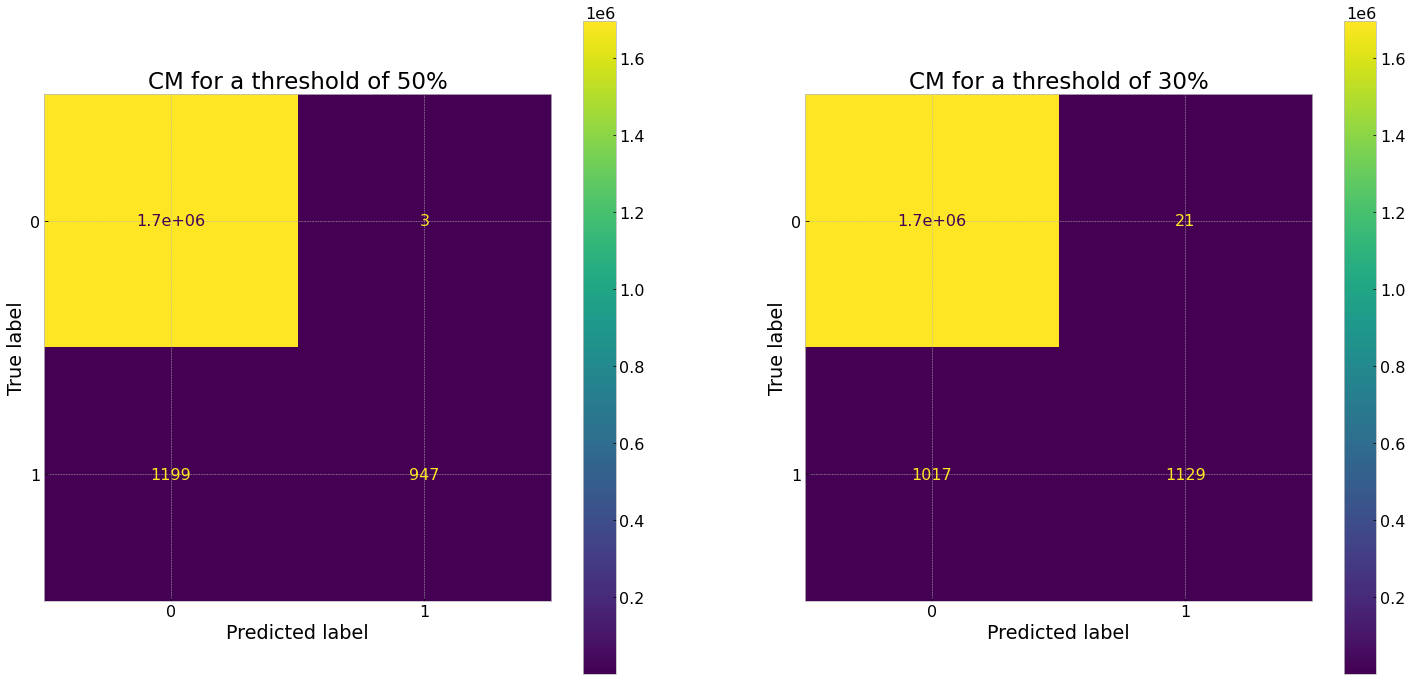

In [15]:
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 50%')

# 30 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 30%');

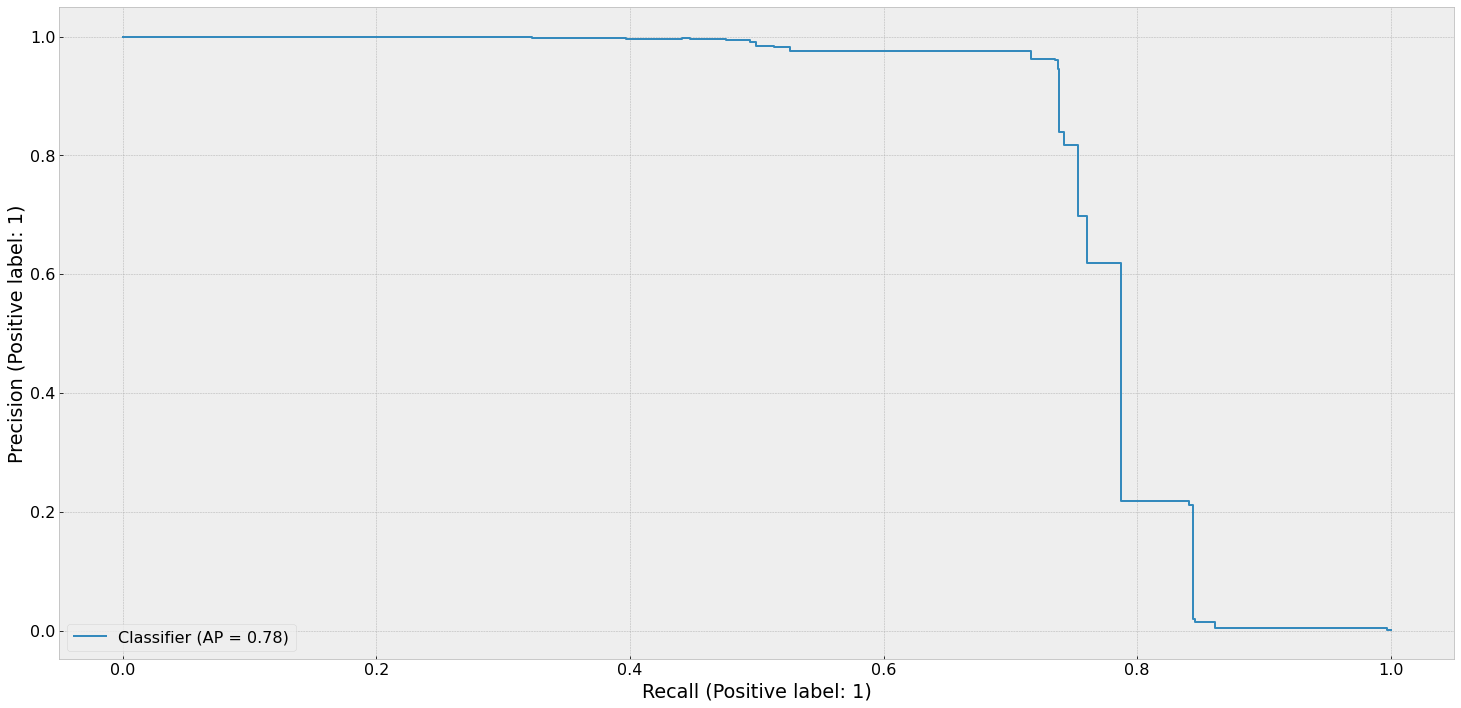

In [16]:
PrecisionRecallDisplay.from_predictions(y_true=results_pd.y_true, y_pred = results_pd.y_pred);

In [17]:
from sklearn.metrics import recall_score, precision_score
# testing a few thresholds

threshold = 0.05
print('precision: {:.4f}'.format(precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)))
print('recall:    {:.4f}'.format(recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)))

precision: 0.7182
recall:    0.7530


In [31]:
#  i = 0
val_df = d0
train_df = d1.unionAll(d2)

model_0 = logistic_pipe.fit(train_df)
results_0 = model_0.transform(val_df)

# 13 minutes runing and returned ConnectionRefusedError: [Errno 111] Connection refused

22/04/29 09:57:27 WARN BlockManager: Block rdd_54_0 already exists on this machine; not re-adding it
22/04/29 09:57:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 09:57:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 09:57:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/29 09:57:39 WARN MemoryStore: Not enough space to cache rdd_13_2 in memory! (computed 76.7 MiB so far)
22/04/29 09:57:39 WARN BlockManager: Persisting block rdd_13_2 to disk instead.
22/04/29 09:57:59 WARN MemoryStore: Not enough space to cache rdd_54_1 in memory! (computed 30.0 MiB so far)
22/04/29 09:57:59 WARN BlockManager: Persisting block rdd_54_1 to disk instead.
22/04/29 09:58:03 WARN MemoryStore: Not enough space to cache rdd_54_2 in memory! (computed 59.0 MiB so far)
22/04/29 09:58:03 WARN BlockManager: Persisting block rdd_54_

ConnectionRefusedError: [Errno 111] Connection refused

# 7.0 Model Testing

## 7.1 Logistic Regression

In [18]:
experiment_id = '1'

In [47]:
mlflow.start_run(experiment_id=experiment_id, run_name='logistic regression L1')

# defining model
lr1 = LogisticRegression(featuresCol='features', labelCol='is_fraud', regParam=1.0)

# reading params
param_el = lr1.getElasticNetParam()
param_ad = lr1.getAggregationDepth()
param_fi = lr1.getFitIntercept()

# logging params
params = { 'Elastic Net' : param_el, "Aggregation Depth" : param_ad, "Fit Intercept" : param_fi }
mlflow.log_params(params=params)

model_1 = lr1.fit(train)
results = model_1.transform(test)

In [48]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

In [49]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)

/home/humberto/.pyenv/versions/3.8.0/envs/pyspark/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}
mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)

In [51]:
mlflow.end_run()

In [44]:
del results_pd
gc.collect()

1547

In [26]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator(labelCol= 'is_fraud')

# evaluator.evaluate(results)

# spark evaluator inflates results

0.9945717506379729

## 7.2 Naive Bayes

In [5]:
experiment_id = '1'

In [6]:
mlflow.start_run(experiment_id=experiment_id, run_name = 'NB gaussian')

# instantiating classifier
nb_model = NaiveBayes(featuresCol='features', labelCol='is_fraud', modelType='gaussian')

# getting params
param_type = nb_model.getModelType()
param_smoothing = nb_model.getSmoothing()

# logging params
mlflow.log_param( "Model Type", param_type )
mlflow.log_param( "Smoothing", param_smoothing )

#model
nb_model_1 = nb_model.fit(train)
results = nb_model_1.transform(test)

In [10]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

22/04/29 19:10:41 WARN TransportClientFactory: DNS resolution succeed for 1berto/192.168.15.52:43739 took 2697 ms
22/04/29 19:10:41 WARN TransportClientFactory: DNS resolution succeed for 1berto/192.168.15.52:43739 took 2697 ms


In [11]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

# mlflow.log_param("threshold", threshold)
# mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.8073082472276609,
 'Area_PR': 0.01655147635320018,
 'Precision': 0.030368128112489016,
 'Recall': 0.18633912522468543}

In [12]:
mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)

In [13]:
mlflow.end_run()

## 7.3 Random Forest

### 7.3.1. Random Forest Using All Features

In [6]:
experiment_id = '1'

In [7]:
# start logging
mlflow.start_run(experiment_id=experiment_id, run_name='RF with all features')

# RF using all features
rf0 = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=42, numTrees=10)

# model params
params = {"Impurity" : rf0.getImpurity(),
"MaxBins" : rf0.getMaxBins(),
"MaxDepth" : rf0.getMaxDepth(),
"NumTrees" : rf0.getNumTrees(),
"Seed" : rf0.getSeed(),
"MinInfoGain" : rf0.getMinInfoGain()}

mlflow.log_params(params)

# model fit predict
model_0 = rf0.fit(train)
results = model_0.transform(test)

In [8]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

In [30]:
# model_0.getFeat

# vector asslembler's cols
# va_cols = model_0.getInputCols()
va_cols = prep_pipe.getStages()[-1].getInputCols()


# model features' importance
feat_imp = model_0.featureImportances

# saving in a dict
aux = dict(zip(va_cols, feat_imp))

#sorting 
features = {k: v for k, v in sorted(aux.items(), key = lambda x: x[1], reverse=True) }
features

{'old_balance_org': 0.34931530171717706,
 'new_balance_dest': 0.29477246648955635,
 'old_balance_dest': 0.07421359572005681,
 'amount': 0.07136215406397364,
 'new_balance_org': 0.0510389465837258,
 'delta_balance_dest': 0.04054691205732011,
 'hour': 0.037731519820129365,
 'delta_balance_org': 0.011778084302479869,
 'type_ohe': 0.0012000638911116258,
 'is_flagged_fraud': 0.0}

In [31]:
# logging feature importances
mlflow.log_dict(features, 'all_features_importance.json')

In [32]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.9845900956815228,
 'Area_PR': 0.7674108267830395,
 'Precision': 0.9973753280839895,
 'Recall': 0.45536249251048533}

In [34]:
mlflow.end_run()

In [6]:
experiment_id = '1'

In [9]:
%%time
# start logging
mlflow.start_run(experiment_id=experiment_id, run_name='RF with all features + 20 trees')

# RF using all features
rf0 = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=42, numTrees=20)

# model params
params = {"Impurity" : rf0.getImpurity(),
"MaxBins" : rf0.getMaxBins(),
"MaxDepth" : rf0.getMaxDepth(),
"NumTrees" : rf0.getNumTrees(),
"Seed" : rf0.getSeed(),
"MinInfoGain" : rf0.getMinInfoGain()}

mlflow.log_params(params)

# model fit predict
model_0 = rf0.fit(train)
results = model_0.transform(test)

CPU times: user 250 ms, sys: 59.7 ms, total: 310 ms
Wall time: 3min 54s


In [7]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [11]:
%%time
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_fraud', metricName='areaUnderPR')

evaluator.evaluate(results)

CPU times: user 193 ms, sys: 87.3 ms, total: 281 ms
Wall time: 6min 37s


0.7678912602304129

In [12]:
%%time
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_fraud', metricName='areaUnderROC')

evaluator.evaluate(results)

CPU times: user 72.8 ms, sys: 37.2 ms, total: 110 ms
Wall time: 3min 41s


0.9877320642644818

In [8]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [13]:
%%time
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

CPU times: user 44.2 s, sys: 1.89 s, total: 46.1 s
Wall time: 5min 26s


In [14]:
# model_0.getFeat

# vector asslembler's cols
# va_cols = model_0.getInputCols()
va_cols = prep_pipe.getStages()[-1].getInputCols()


# model features' importance
feat_imp = model_0.featureImportances

# saving in a dict
aux = dict(zip(va_cols, feat_imp))

#sorting 
features = {k: v for k, v in sorted(aux.items(), key = lambda x: x[1], reverse=True) }
features

{'old_balance_org': 0.4006346363816082,
 'new_balance_dest': 0.24570971565693012,
 'delta_balance_dest': 0.06592218989249,
 'amount': 0.06429322394220902,
 'old_balance_dest': 0.04566063759452667,
 'hour': 0.044680620857401064,
 'delta_balance_org': 0.03797982417497699,
 'new_balance_org': 0.008575521987454069,
 'type_ohe': 0.003913653393192304,
 'is_flagged_fraud': 0.0}

In [15]:
# logging feature importances
mlflow.log_dict(features, 'all_features_importance.json')

In [16]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.9877320642644818,
 'Area_PR': 0.7653759540809282,
 'Precision': 0.9974554707379135,
 'Recall': 0.46974236069502695}

In [25]:
results.show()

In [17]:
%%time
# Make prediction
test_results = results.select("is_fraud", "prediction")
predictionAndTarget = test.select("target", "prediction")

# Create both evaluators
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

acc = metrics_multi.accuracy
f1 = metrics_multi.fMeasure(1.0)
precision = metrics_multi.precision(1.0)
recall = metrics_multi.recall(1.0)
auc = metrics_binary.areaUnderROC

AnalysisException: cannot resolve 'target' given input columns: [amount, delta_balance_dest, delta_balance_org, features, hour, is_flagged_fraud, is_fraud, name_dest, name_orig, new_balance_dest, new_balance_org, old_balance_dest, old_balance_org, step, type, type_idx, type_ohe];
'Project ['target, 'prediction]
+- ExceptAll true
   :- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, type_ohe#228, features#253]
   :  +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, type_ohe#228, features#253]
   :     +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, type_ohe#228, features#253]
   :        +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, type_ohe#228, features#253]
   :           +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, type_ohe#228, UDF(struct(amount, amount#117, old_balance_org, old_balance_org#118, new_balance_org, new_balance_org#119, old_balance_dest, old_balance_dest#120, new_balance_dest, new_balance_dest#121, is_flagged_fraud_double_VectorAssembler_e797b9921940, cast(is_flagged_fraud#123 as double), hour, hour#124, delta_balance_org, delta_balance_org#125, delta_balance_dest, delta_balance_dest#126, type_ohe, type_ohe#228)) AS features#253]
   :              +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, type_idx#205, UDF(cast(type_idx#205 as double), 0) AS type_ohe#228]
   :                 +- Project [step#116, type#39, amount#117, name_orig#41, old_balance_org#118, new_balance_org#119, name_dest#44, old_balance_dest#120, new_balance_dest#121, is_fraud#122, is_flagged_fraud#123, hour#124, delta_balance_org#125, delta_balance_dest#126, UDF(cast(type#39 as string)) AS type_idx#205]
   :                    +- Project [coalesce(step#38, cast(0.0 as int)) AS step#116, type#39, coalesce(nanvl(amount#40, cast(null as double)), cast(0.0 as double)) AS amount#117, name_orig#41, coalesce(nanvl(old_balance_org#42, cast(null as double)), cast(0.0 as double)) AS old_balance_org#118, coalesce(nanvl(new_balance_org#43, cast(null as double)), cast(0.0 as double)) AS new_balance_org#119, name_dest#44, coalesce(nanvl(old_balance_dest#45, cast(null as double)), cast(0.0 as double)) AS old_balance_dest#120, coalesce(nanvl(new_balance_dest#46, cast(null as double)), cast(0.0 as double)) AS new_balance_dest#121, coalesce(is_fraud#47, cast(0.0 as int)) AS is_fraud#122, coalesce(is_flagged_fraud#48, cast(0.0 as int)) AS is_flagged_fraud#123, coalesce(nanvl(hour#60, cast(null as double)), cast(0.0 as double)) AS hour#124, coalesce(nanvl(delta_balance_org#73, cast(null as double)), cast(0.0 as double)) AS delta_balance_org#125, coalesce(nanvl(delta_balance_dest#87, cast(null as double)), cast(0.0 as double)) AS delta_balance_dest#126]
   :                       +- Project [step#38, type#39, amount#40, name_orig#41, old_balance_org#42, new_balance_org#43, name_dest#44, old_balance_dest#45, new_balance_dest#46, is_fraud#47, is_flagged_fraud#48, hour#60, delta_balance_org#73, ((new_balance_dest#46 - old_balance_dest#45) / old_balance_dest#45) AS delta_balance_dest#87]
   :                          +- Project [step#38, type#39, amount#40, name_orig#41, old_balance_org#42, new_balance_org#43, name_dest#44, old_balance_dest#45, new_balance_dest#46, is_fraud#47, is_flagged_fraud#48, hour#60, ((new_balance_org#43 - old_balance_org#42) / old_balance_org#42) AS delta_balance_org#73]
   :                             +- Project [step#38, type#39, amount#40, name_orig#41, old_balance_org#42, new_balance_org#43, name_dest#44, old_balance_dest#45, new_balance_dest#46, is_fraud#47, is_flagged_fraud#48, (cast(step#38 as double) % 24.0) AS hour#60]
   :                                +- Project [step#16 AS step#38, type#17 AS type#39, amount#18 AS amount#40, nameOrig#19 AS name_orig#41, oldbalanceOrg#20 AS old_balance_org#42, newbalanceOrig#21 AS new_balance_org#43, nameDest#22 AS name_dest#44, oldbalanceDest#23 AS old_balance_dest#45, newbalanceDest#24 AS new_balance_dest#46, isFraud#25 AS is_fraud#47, isFlaggedFraud#26 AS is_flagged_fraud#48]
   :                                   +- Relation [step#16,type#17,amount#18,nameOrig#19,oldbalanceOrg#20,newbalanceOrig#21,nameDest#22,oldbalanceDest#23,newbalanceDest#24,isFraud#25,isFlaggedFraud#26] csv
   +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, type_ohe#305, features#304]
      +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, type_ohe#305, features#304]
         +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, type_ohe#305, features#304]
            +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, type_ohe#305, features#304]
               +- Filter UDF(is_fraud#313, rand(42))
                  +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, type_ohe#305, UDF(struct(amount, amount#308, old_balance_org, old_balance_org#309, new_balance_org, new_balance_org#310, old_balance_dest, old_balance_dest#311, new_balance_dest, new_balance_dest#312, is_flagged_fraud_double_VectorAssembler_e797b9921940, cast(is_flagged_fraud#314 as double), hour, hour#315, delta_balance_org, delta_balance_org#316, delta_balance_dest, delta_balance_dest#317, type_ohe, type_ohe#305)) AS features#304]
                     +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, type_idx#306, UDF(cast(type_idx#306 as double), 0) AS type_ohe#305]
                        +- Project [step#307, type#319, amount#308, name_orig#321, old_balance_org#309, new_balance_org#310, name_dest#324, old_balance_dest#311, new_balance_dest#312, is_fraud#313, is_flagged_fraud#314, hour#315, delta_balance_org#316, delta_balance_dest#317, UDF(cast(type#319 as string)) AS type_idx#306]
                           +- Project [coalesce(step#318, cast(0.0 as int)) AS step#307, type#319, coalesce(nanvl(amount#320, cast(null as double)), cast(0.0 as double)) AS amount#308, name_orig#321, coalesce(nanvl(old_balance_org#322, cast(null as double)), cast(0.0 as double)) AS old_balance_org#309, coalesce(nanvl(new_balance_org#323, cast(null as double)), cast(0.0 as double)) AS new_balance_org#310, name_dest#324, coalesce(nanvl(old_balance_dest#325, cast(null as double)), cast(0.0 as double)) AS old_balance_dest#311, coalesce(nanvl(new_balance_dest#326, cast(null as double)), cast(0.0 as double)) AS new_balance_dest#312, coalesce(is_fraud#327, cast(0.0 as int)) AS is_fraud#313, coalesce(is_flagged_fraud#328, cast(0.0 as int)) AS is_flagged_fraud#314, coalesce(nanvl(hour#60, cast(null as double)), cast(0.0 as double)) AS hour#315, coalesce(nanvl(delta_balance_org#73, cast(null as double)), cast(0.0 as double)) AS delta_balance_org#316, coalesce(nanvl(delta_balance_dest#87, cast(null as double)), cast(0.0 as double)) AS delta_balance_dest#317]
                              +- Project [step#318, type#319, amount#320, name_orig#321, old_balance_org#322, new_balance_org#323, name_dest#324, old_balance_dest#325, new_balance_dest#326, is_fraud#327, is_flagged_fraud#328, hour#60, delta_balance_org#73, ((new_balance_dest#326 - old_balance_dest#325) / old_balance_dest#325) AS delta_balance_dest#87]
                                 +- Project [step#318, type#319, amount#320, name_orig#321, old_balance_org#322, new_balance_org#323, name_dest#324, old_balance_dest#325, new_balance_dest#326, is_fraud#327, is_flagged_fraud#328, hour#60, ((new_balance_org#323 - old_balance_org#322) / old_balance_org#322) AS delta_balance_org#73]
                                    +- Project [step#318, type#319, amount#320, name_orig#321, old_balance_org#322, new_balance_org#323, name_dest#324, old_balance_dest#325, new_balance_dest#326, is_fraud#327, is_flagged_fraud#328, (cast(step#318 as double) % 24.0) AS hour#60]
                                       +- Project [step#293 AS step#318, type#294 AS type#319, amount#295 AS amount#320, nameOrig#296 AS name_orig#321, oldbalanceOrg#297 AS old_balance_org#322, newbalanceOrig#298 AS new_balance_org#323, nameDest#299 AS name_dest#324, oldbalanceDest#300 AS old_balance_dest#325, newbalanceDest#301 AS new_balance_dest#326, isFraud#302 AS is_fraud#327, isFlaggedFraud#303 AS is_flagged_fraud#328]
                                          +- Relation [step#293,type#294,amount#295,nameOrig#296,oldbalanceOrg#297,newbalanceOrig#298,nameDest#299,oldbalanceDest#300,newbalanceDest#301,isFraud#302,isFlaggedFraud#303] csv


In [ ]:
mlflow.end_run()

### 7.3.2. Random Forest Using Less Features

In [48]:
%%time
data = spark.read.csv('../data/raw/fraud.csv', header = True, inferSchema=True) #.cache()

# new column names
cols = ['step',
 'type',
 'amount',
 'name_orig',
 'old_balance_org',
 'new_balance_org',
 'name_dest',
 'old_balance_dest',
 'new_balance_dest',
 'is_fraud',
 'is_flagged_fraud']
data = data.toDF(*cols)

# creating features
data = data.withColumn("hour", data['step']%24.0)
data = data.withColumn('delta_balance_org', (data['new_balance_org'] - data['old_balance_org'])/data['old_balance_org'] )
data = data.withColumn('delta_balance_dest', (data['new_balance_dest'] - data['old_balance_dest'])/data['old_balance_dest'] )

# Selecting cols and transformers to apply RF
num_cols = ['amount','old_balance_org','new_balance_org','old_balance_dest','new_balance_dest', 'hour','delta_balance_org','delta_balance_dest']
data = data.fillna(0)

# preprocessing
selected_cols = num_cols

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

prep_pipe = Pipeline(stages=[ vec_asm ])

data = prep_pipe.fit(data).transform(data)

CPU times: user 28.2 ms, sys: 4.16 ms, total: 32.3 ms
Wall time: 25.6 s


In [49]:
# spliting

train = data.sampleBy( col='is_fraud', fractions = {0:0.8, 1:0.8}, seed = 42 )
test = data.exceptAll(train)

data.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour: double, delta_balance_org: double, delta_balance_dest: double, features: vector]

In [37]:
experiment_id = '1'

In [59]:
# start logging
mlflow.start_run(experiment_id=experiment_id, run_name='RF using less features +5 trees')

# RF using all features
rf0 = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=42, numTrees=5)

# model params
params = {"Impurity" : rf0.getImpurity(),
"MaxBins" : rf0.getMaxBins(),
"MaxDepth" : rf0.getMaxDepth(),
"NumTrees" : rf0.getNumTrees(),
"Seed" : rf0.getSeed(),
"MinInfoGain" : rf0.getMinInfoGain()}

mlflow.log_params(params)

# model fit predict
model_0 = rf0.fit(train)
results = model_0.transform(test)

In [60]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

In [61]:
# prep_pipe.stages[-1].getInputCols()
prep_pipe.getStages()[-1].getInputCols()

['amount',
 'old_balance_org',
 'new_balance_org',
 'old_balance_dest',
 'new_balance_dest',
 'hour',
 'delta_balance_org',
 'delta_balance_dest']

In [62]:
model_0.featureImportances


SparseVector(8, {0: 0.1073, 1: 0.5794, 2: 0.0272, 3: 0.0183, 4: 0.131, 5: 0.0361, 6: 0.0806, 7: 0.0201})

In [64]:
# model_0.getFeat

# vector asslembler's cols
# va_cols = model_0.getInputCols()
va_cols = prep_pipe.getStages()[-1].getInputCols()


# model features' importance
feat_imp = model_0.featureImportances

# saving in a dict
aux = dict(zip(va_cols, feat_imp))

#sorting 
features = {k: v for k, v in sorted(aux.items(), key = lambda x: x[1], reverse=True) }
features

{'old_balance_org': 0.5793997774231513,
 'new_balance_dest': 0.1310139499479454,
 'amount': 0.10729017828415004,
 'delta_balance_org': 0.08057870050211516,
 'hour': 0.0361003564516096,
 'new_balance_org': 0.027227185616972432,
 'delta_balance_dest': 0.02010482086357043,
 'old_balance_dest': 0.018285030910485712}

In [65]:
# logging feature importances
mlflow.log_dict(features, 'all_features_importance.json')

In [66]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.9724020973298242,
 'Area_PR': 0.6189874481871451,
 'Precision': 0.9755725190839695,
 'Recall': 0.38286399041342123}

In [58]:
mlflow.end_run()

## 7.4 GB Trees

In [6]:
from pyspark.ml.classification import GBTClassifier

In [10]:
gbt = GBTClassifier(labelCol='is_fraud', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
                    lossType='logistic', impurity='gini', featureSubsetStrategy='all', maxIter=5, seed = 42)

In [30]:
# start logging

# experiment_id
experiment_id = '1'
# mlflow.start_run(experiment_id=experiment_id, run_name='GBTress +10 depth')

# model
gbt = GBTClassifier(labelCol='is_fraud', maxDepth=10, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
                    lossType='logistic', impurity='variance', featureSubsetStrategy='all', maxIter=5, seed = 42)

# model params
params = {"MaxDepth" : gbt.getMaxDepth(),
"MaxBins" : gbt.getMaxBins(),
"MinInstancesPerNode" : gbt.getMinInstancesPerNode(),
"MinInfoGain" : gbt.getMinInfoGain(),
"FeatureSubsetStrategy" : gbt.getFeatureSubsetStrategy(),
"MaxIter" : gbt.getMaxIter(),
"impurity" : gbt.getImpurity(),
"Seed " : gbt.getSeed()}

mlflow.log_params(params)

# model fit predict
model_0 = gbt.fit(train)
results = model_0.transform(test)

In [31]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

In [32]:
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

mlflow.log_param("threshold", threshold)
mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.9963935648770119,
 'Area_PR': 0.881286567049733,
 'Precision': 0.9536423841059603,
 'Recall': 0.7765128819652487}

In [33]:
mlflow.end_run()

In [34]:
# testing model on train data to check if no overfitting is happening
results = model_0.transform(train)

In [35]:
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')
# evaluating result metrics
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

# mlflow.log_param("threshold", threshold)
# mlflow.log_metrics(metrics)
metrics

# scores on train and test sets are virtually the same. Probably, increasing depth beyond this point will result in overfitting

{'F1-Score': 0.9987227255121237,
 'Area_PR': 0.8952097014036616,
 'Precision': 0.9719278676333891,
 'Recall': 0.7988997555012225}

## 7.5 LightGBM

In [7]:
from synapse.ml.lightgbm import LightGBMClassifier

In [8]:
# start logging

# experiment_id
experiment_id = '2'
# mlflow.start_run(experiment_id=experiment_id, run_name='LightGBM')

# model
lgbm = LightGBMClassifier(labelCol='is_fraud', objective='binary', featuresCol='features', baggingSeed=42, 
                          numIterations=50,
                          maxDepth=5, 
                          learningRate=0.01,
                          isUnbalance=False
                          )
# model params
params = {"NumIterations" : lgbm.getNumIterations(),
"MaxBin" : lgbm.getMaxBin(),
"MaxDepth" : lgbm.getMaxDepth()
}

# mlflow.log_params(params)

# model fit predict
model_0 = lgbm.fit(train)
results = model_0.transform(validation)

In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [48]:
%%time
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderPR', numBins=1000)
evaluator.evaluate(results)

CPU times: user 89.6 ms, sys: 28 ms, total: 118 ms
Wall time: 5min 7s


0.8283804375011014

In [9]:
%%time
# converting results to pandas
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

CPU times: user 50.5 s, sys: 2.13 s, total: 52.7 s
Wall time: 17min 46s


In [10]:
# evaluating result metrics of valitation set
threshold = 0.5
metric_f1 = roc_auc_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_ap = average_precision_score(y_true = results_pd.y_true, y_score = results_pd.y_pred)
metric_precision = precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
metric_recall = recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)
# logging metrics
metrics = {"F1-Score": metric_f1 ,
           "Area_PR": metric_ap ,
           "Precision": metric_precision ,
           "Recall": metric_recall}

# mlflow.log_param("threshold", threshold)
# mlflow.log_metrics(metrics)
metrics

{'F1-Score': 0.9972547793121794,
 'Area_PR': 0.8397070293198766,
 'Precision': 0.9683544303797469,
 'Recall': 0.46307506053268765}

In [43]:
mlflow.end_run()

# 8.0. Checking model performance

## 8.1. Model Calibration

### 8.1.1 Validation Set

In [11]:
results_pd.head()

,y_pred,y_true
0,0.000773,0
1,0.000773,0
2,0.000773,0
3,0.000773,0
4,0.000773,0


In [12]:
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
cm

array([[1271220,      53],
       [    753,     899]])

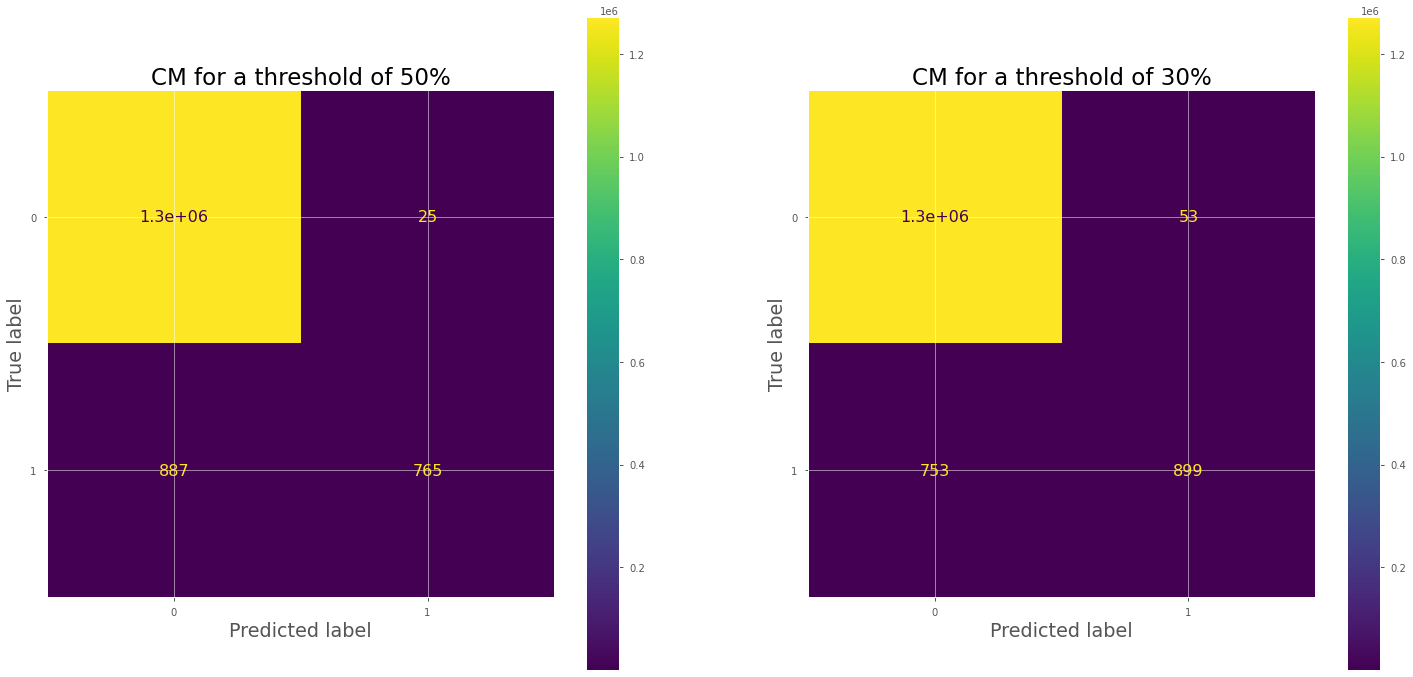

In [29]:
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 50%')

# 30 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 30%');

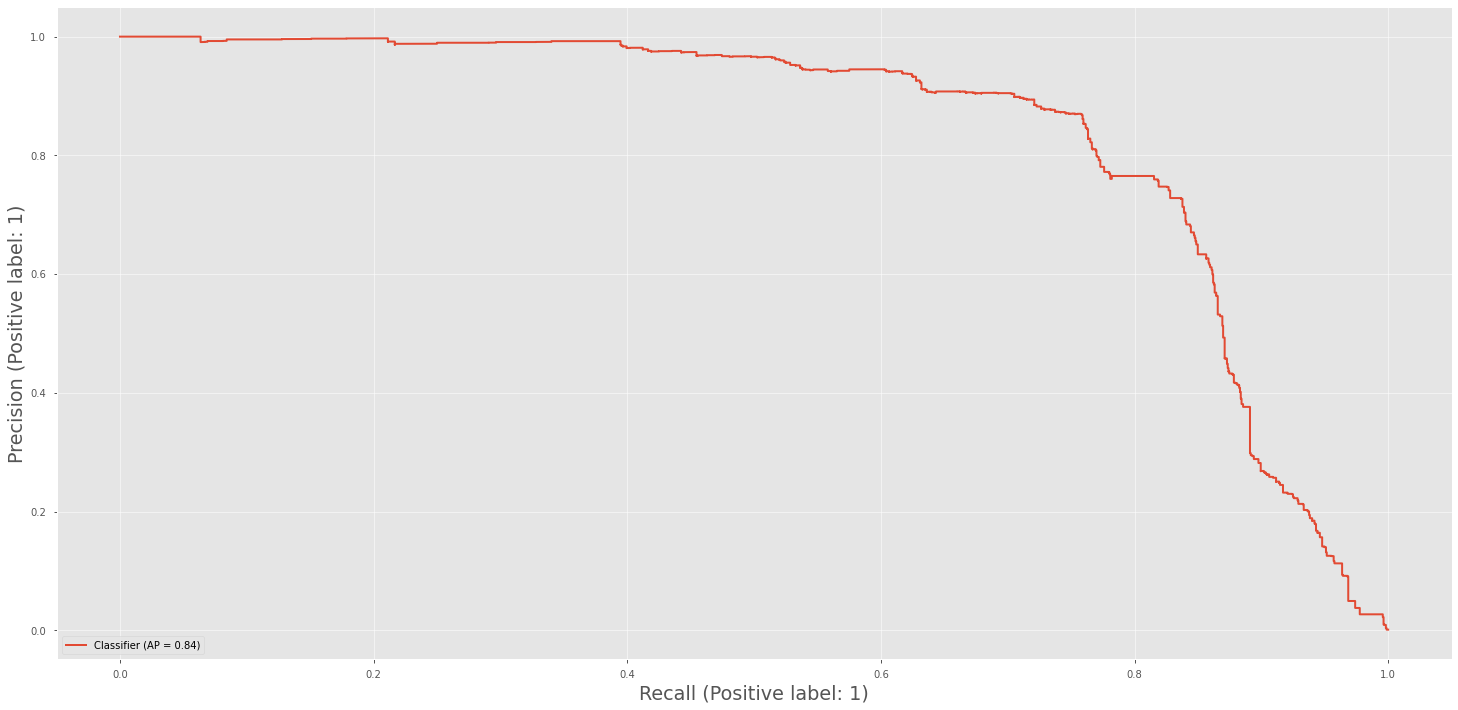

In [30]:
PrecisionRecallDisplay.from_predictions(y_true=results_pd.y_true, y_pred = results_pd.y_pred);

In [18]:
from sklearn.calibration import calibration_curve

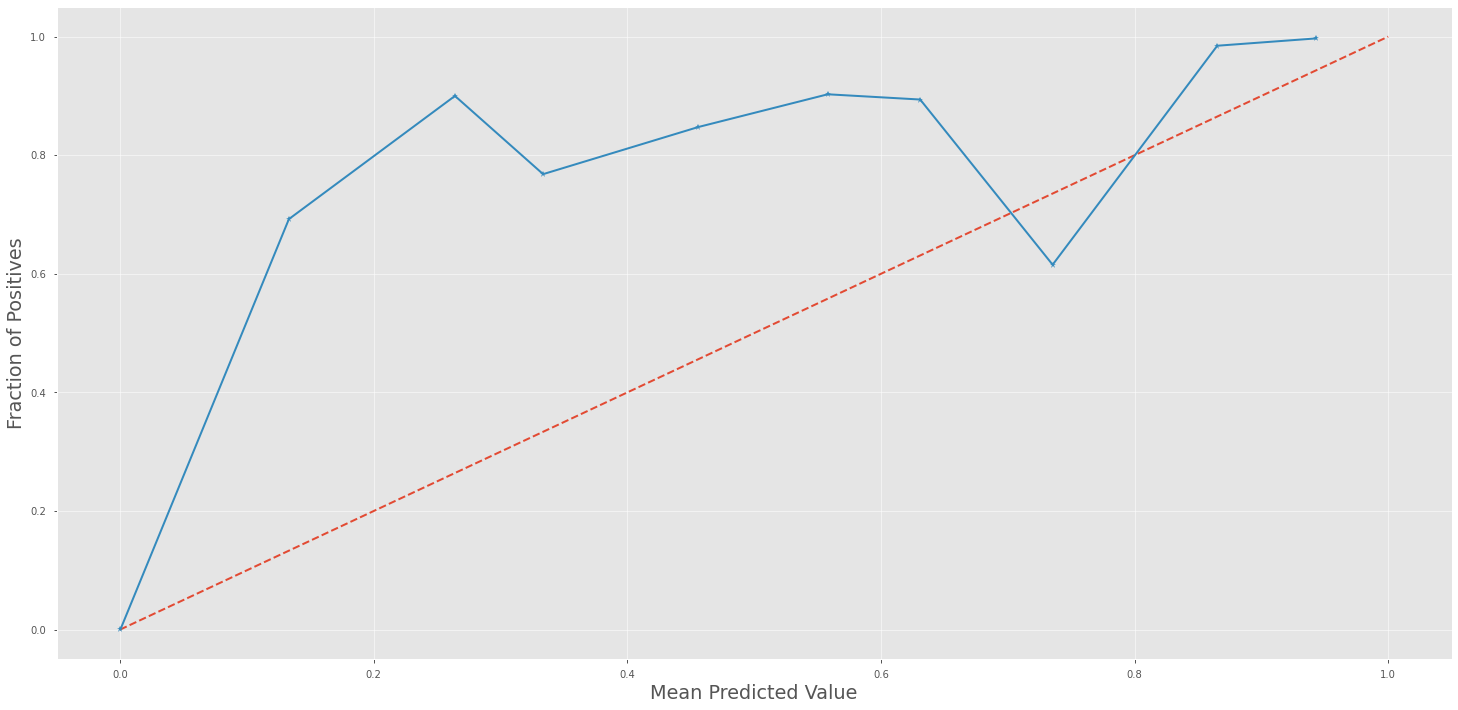

In [31]:
# calibration curve of validation set

# returning fraction of positives and mean predicted value
fop, mpv = calibration_curve(y_true=results_pd.y_true, y_prob = results_pd.y_pred, normalize = True, n_bins = 10);
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.plot(mpv, fop, marker='*');

In [32]:
from sklearn.linear_model import LogisticRegression

In [112]:
lr = LogisticRegression(fit_intercept=True, C=0.001, solver='sag')
lr = LogisticRegression()
# model probabilities
X = results_pd['y_pred'].values.reshape(-1,1)
y = results_pd['y_true']

lr.fit(X,y)
intercept = lr.intercept_[0]
coef = lr.coef_[0][0]
print("coeficient: {:.2f}".format(coef))
print("intercept: {:.2f}".format(intercept))

coeficient: 25.52
intercept: -7.58


In [118]:
y_applied = lr.predict_proba(X)[:,1]
y_applied

array([0.00052271, 0.00052271, 0.00052271, ..., 0.00052283, 0.00052283,
       0.00053667])

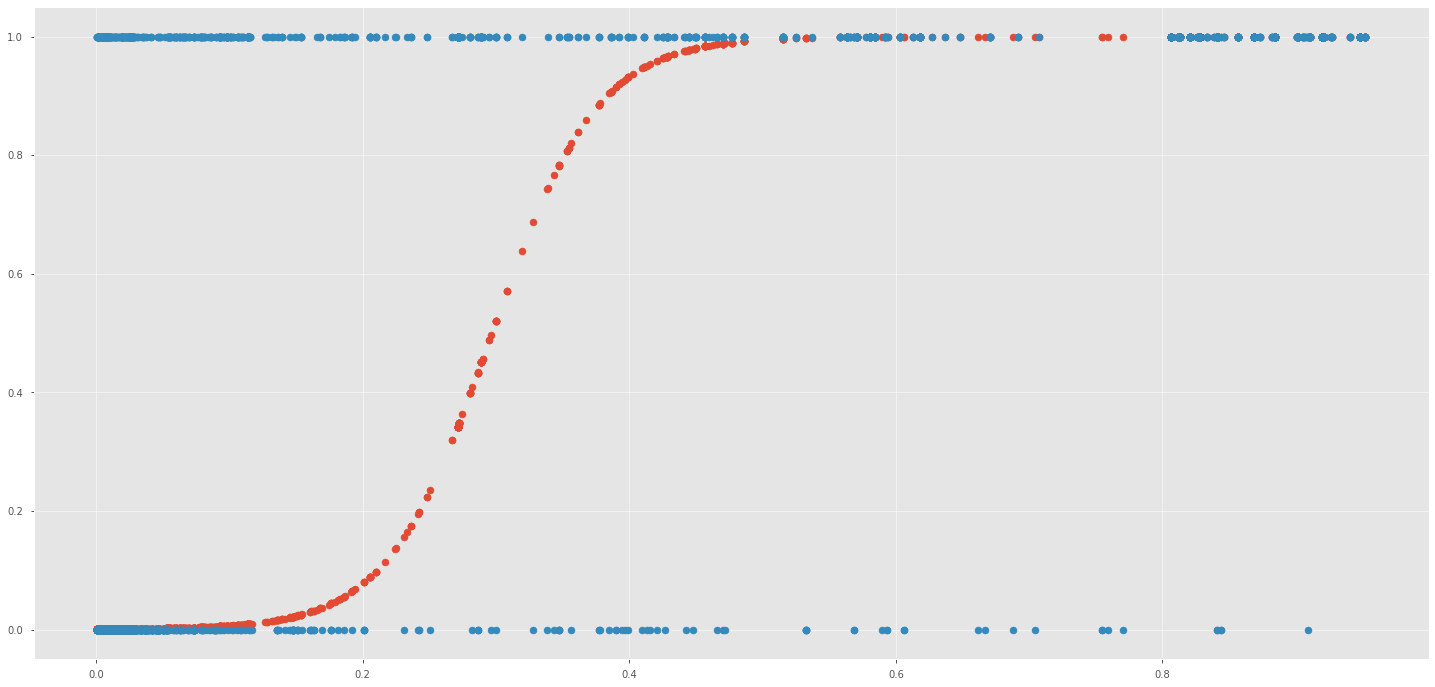

In [119]:
# taking a look at data

plt.scatter(X, y_applied)
plt.scatter(X,y);

### 8.1.2 Test Set

In [44]:
# predicting test set 
results_test = model_0.transform(test)

In [45]:
%%time
# converting test set results to pandas
test_pd = proba_to_pandas(dataframe = results_test, prob_col='probability', label_col='is_fraud')

CPU times: user 54.8 s, sys: 2.53 s, total: 57.3 s
Wall time: 14min 9s


In [120]:
# calibrating test probabilities

test_prbs = test_pd['y_pred'].values.reshape(-1,1)

# getting predictions of positive class
cal_probs = lr.predict_proba(test_prbs)[:,1]

In [121]:
# it seems like logistic regression actually reduced probabilities that were already low
cal_probs

array([0.0005228 , 0.0005228 , 0.00052271, ..., 0.00052283, 0.00053667,
       0.00052271])

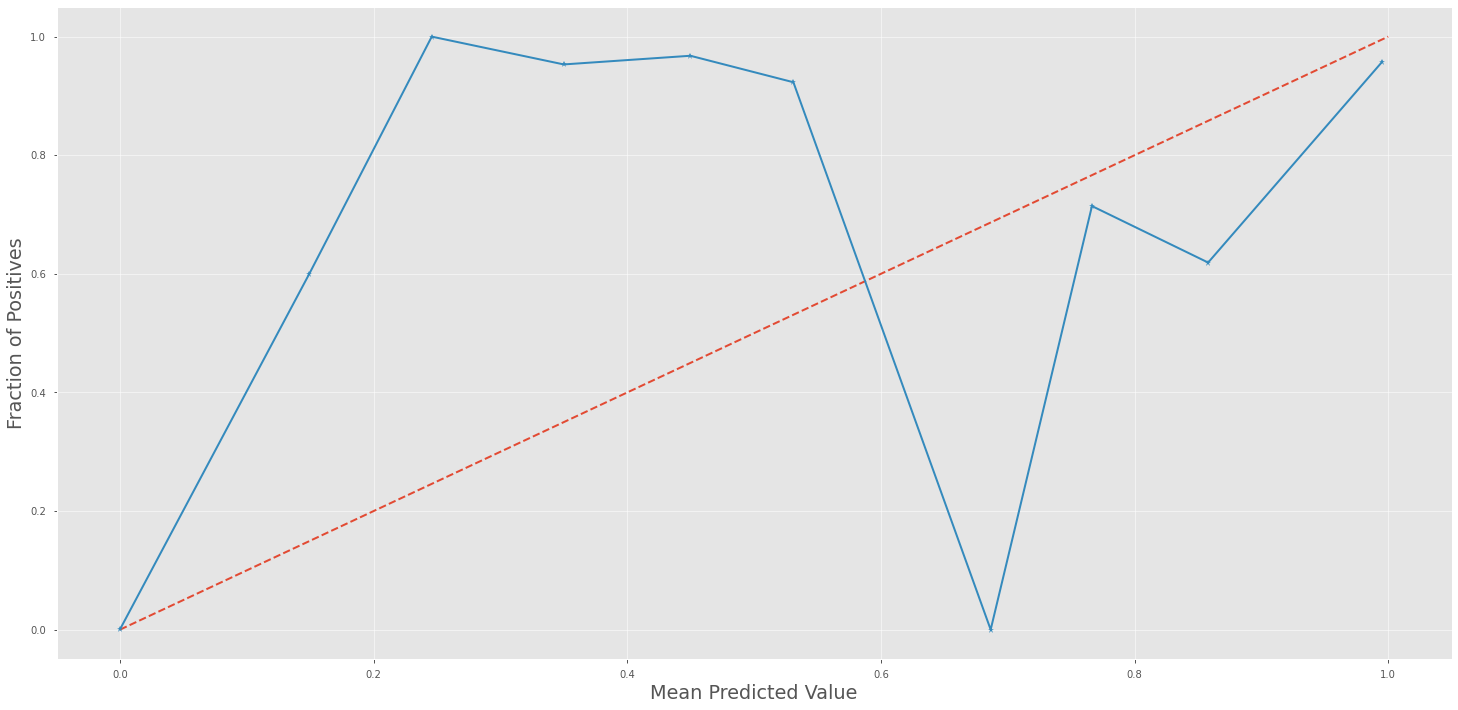

In [122]:
# returning fraction of positives and mean predicted value
fop, mpv = calibration_curve(y_true = test_pd.y_true, y_prob = cal_probs, normalize = True, n_bins = 10);
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.plot(mpv, fop, marker='*');

In [68]:
test_pd.head()

,y_pred,y_true
0,0.000780,0
1,0.000780,0
2,0.000773,0
3,0.000804,0
4,0.000773,0


In [73]:
test_calibrated_pd = pd.DataFrame( {'y_proba' : cal_probs, 'y_true' : test_pd.y_true } )
test_calibrated_pd.head()

,y_proba,y_true
0,0.000523,0
1,0.000523,0
2,0.000523,0
3,0.000523,0
4,0.000523,0


In [74]:
# calibrated probas

from sklearn.metrics import recall_score, precision_score

# testing a few thresholds
thresholds = [0.5, 0.3, 0.05]

for threshold in thresholds:
    print('threshold: {}'.format(threshold))
    print('precision: {:.4f}'.format(precision_score(y_true=test_calibrated_pd.y_true, y_pred = test_calibrated_pd.y_proba > threshold)))
    print('recall:    {:.4f}\n'.format(recall_score(y_true=test_calibrated_pd.y_true, y_pred = test_calibrated_pd.y_proba > threshold)))

threshold: 0.5
precision: 0.9465
recall:    0.5427

threshold: 0.3
precision: 0.9476
recall:    0.5974

threshold: 0.05
precision: 0.9408
recall:    0.6208



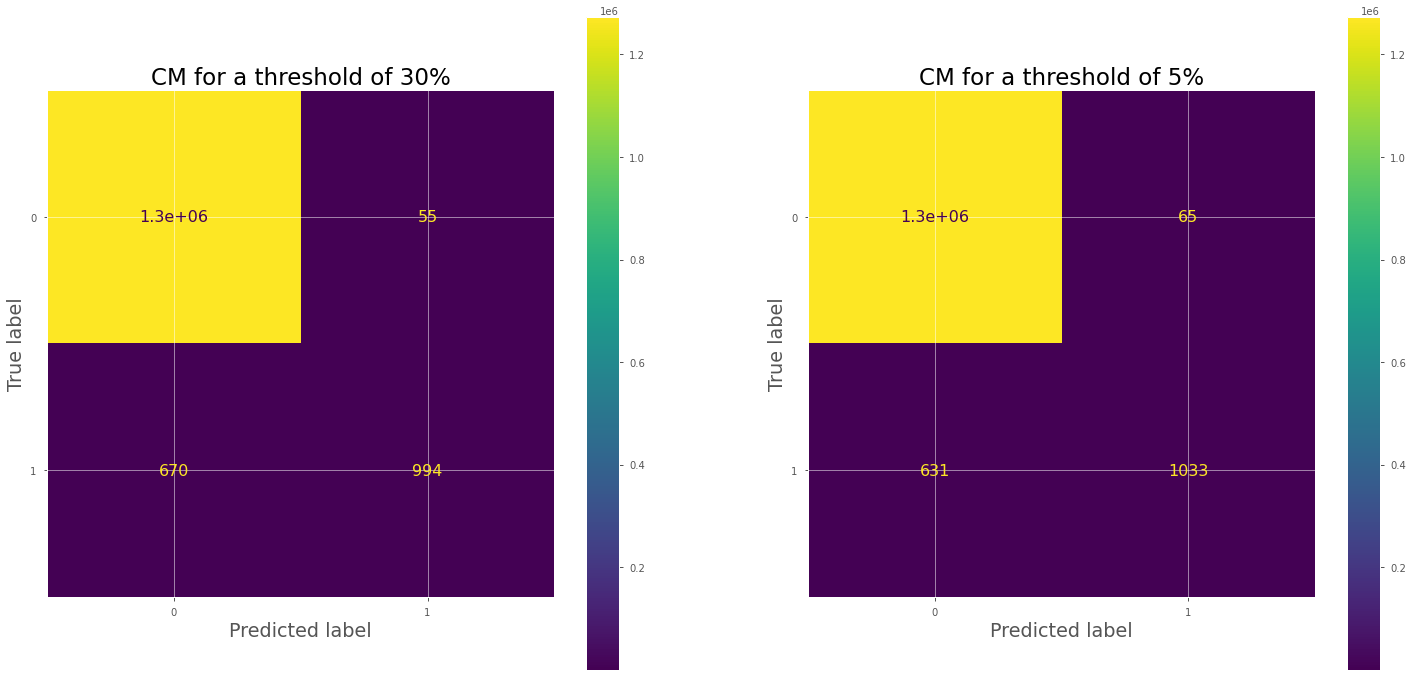

In [77]:
# calibrated probabilities CM
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=test_calibrated_pd.y_true, y_pred=test_calibrated_pd.y_proba > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 30%')

# 30 % threshold
cm = confusion_matrix(y_true=test_calibrated_pd.y_true, y_pred=test_calibrated_pd.y_proba > 0.05)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 5%');

In [81]:
# uncalibrated probas
from sklearn.metrics import recall_score, precision_score
# testing a few thresholds

thresholds = [0.5, 0.3, 0.05, 0.03]

for threshold in thresholds:
    print('threshold: {}'.format(threshold))
    print('precision: {:.4f}'.format(precision_score(y_true=test_pd.y_true, y_pred = test_pd.y_pred > threshold)))
    print('recall:    {:.4f}\n'.format(recall_score(y_true=test_pd.y_true, y_pred = test_pd.y_pred > threshold)))

threshold: 0.5
precision: 0.9622
recall:    0.4435

threshold: 0.3
precision: 0.9465
recall:    0.5421

threshold: 0.05
precision: 0.8631
recall:    0.7542

threshold: 0.03
precision: 0.8050
recall:    0.7692



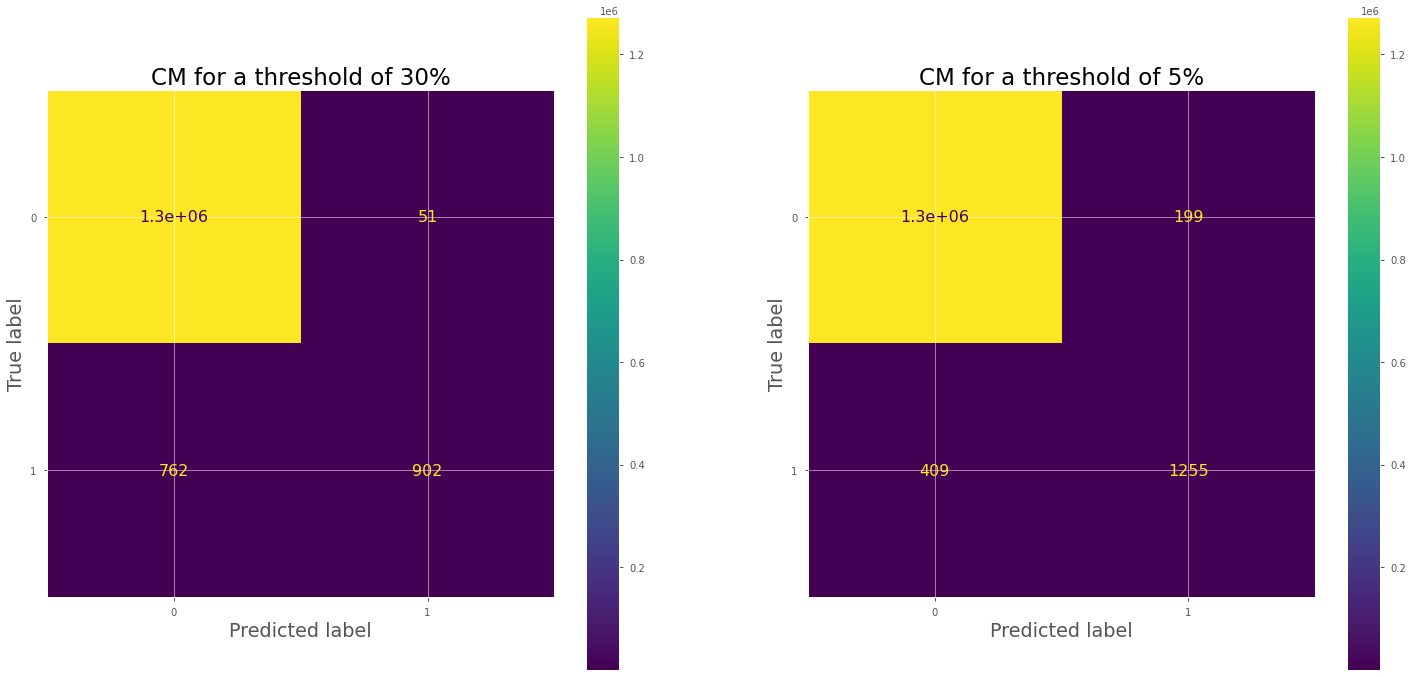

In [80]:
# uncalibrated probabilities CM
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=test_pd.y_true, y_pred=test_pd.y_pred > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 30%')

# 30 % threshold
cm = confusion_matrix(y_true=test_pd.y_true, y_pred=test_pd.y_pred > 0.05)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 5%');

This calibration method was not effective. 

Uncalibrated probabilities are presenting higher precision and recall than "calibrated" ones.

LGBM Classifier seems to not be overfitting, since it performed well on unseen data from test set.

### TO DO:

Perform EDA